In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images
from utils.Preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from utils.logger import save_full_report
from trainer import trainer

# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.9,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "output_base_path" : "./outputs",
    "name" : "Attention7-512capedAug"
}
class_map = {
    0: '1',1: '2', 2: '3',3: '4',
    4: '5',5: '6',6: '7',7: '8',
    8: '9',9: '9a',10: '10',11: '10a',
    12: '11',13: '12',14: '12a',15: '13',
    16: '14',17: '14a',18: '15',19: '16',
    20: '16a',21: '16b',22: '16c',
    23: '12b',24: '14b'
}

In [3]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 25),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [4]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [6]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
recorder = HistoryRecorder(class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0) | loss : 1.7330716651678086 
dice loss : -0.012416441841050983 - bce loss : 1.7454881060123444 
train avg metrics for epoch 0 :
avg dice : 0.0031595320298158603 - avg precision : 0.007638326332598808 - avg recall : 0.005962656080519082
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0) | loss : 0.7347257882356644 
dice loss : -0.015221033990383149 - bce loss : 0.7499468207359314 
valid avg metrics for epoch 0 :
avg dice : 0.006468632840665032 - avg precision : 0.019692456573247908 - avg recall : 0.004633056138845859
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1) | loss : 0.3704906725883484 
dice loss : -0.03629101000726223 - bce loss : 0.40678168311715124 
train avg metrics for epoch 1 :
avg dice : 0.016130083505573534 - avg precision : 0.04260183118283749 - avg recall : 0.016189890565060525
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1) | loss : 0.18068058416247368 
dice loss : -0.06732032317668199 - bce loss : 0.2480009078979492 
valid avg metrics for epoch 1 :
avg dice : 0.02667266491841337 - avg precision : 0.04121416330337525 - avg recall : 0.03202764233574271
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2) | loss : 0.0871406489610672 
dice loss : -0.1163504234701395 - bce loss : 0.20349107220768928 
train avg metrics for epoch 2 :
avg dice : 0.04161889266383519 - avg precision : 0.05114590853452682 - avg recall : 0.06101175562711433
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2) | loss : 0.052423550933599475 
dice loss : -0.1366172857582569 - bce loss : 0.1890408366918564 
valid avg metrics for epoch 2 :
avg dice : 0.05582384198944557 - avg precision : 0.05336382329463959 - avg recall : 0.07537133127450943
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3) | loss : -0.01712900258600712 
dice loss : -0.18321737788617612 - bce loss : 0.16608837530016898 
train avg metrics for epoch 3 :
avg dice : 0.07914674537245808 - avg precision : 0.08641752809286117 - avg recall : 0.09388570998869909
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3) | loss : -0.024976614862680435 
dice loss : -0.19764882922172547 - bce loss : 0.17267221435904503 
valid avg metrics for epoch 3 :
avg dice : 0.0943818799519328 - avg precision : 0.10835423715412616 - avg recall : 0.10655338402473717
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4) | loss : -0.10488591641187668 
dice loss : -0.25438463091850283 - bce loss : 0.14949871435761453 
train avg metrics for epoch 4 :
avg dice : 0.12752647562927658 - avg precision : 0.1319243711233139 - avg recall : 0.1427034141821787
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4) | loss : -0.09956294596195221 
dice loss : -0.2557452566921711 - bce loss : 0.15618231073021888 
valid avg metrics for epoch 4 :
avg dice : 0.13785583586004876 - avg precision : 0.16580145835876464 - avg recall : 0.1461918522499036
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5) | loss : -0.17130942687392234 
dice loss : -0.31018579080700875 - bce loss : 0.13887636415660382 
train avg metrics for epoch 5 :
avg dice : 0.15981167299251078 - avg precision : 0.16165884017944335 - avg recall : 0.17564133518841119
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5) | loss : -0.13999927118420602 
dice loss : -0.2909796848893166 - bce loss : 0.15098041370511056 
valid avg metrics for epoch 5 :
avg dice : 0.16221180193164264 - avg precision : 0.18212629169225691 - avg recall : 0.16918232404626907
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6) | loss : -0.19845100715756417 
dice loss : -0.3350353254377842 - bce loss : 0.13658431828022002 
train avg metrics for epoch 6 :
avg dice : 0.1724203693871107 - avg precision : 0.16765783131122589 - avg recall : 0.18839044339954852
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6) | loss : -0.18528130725026132 
dice loss : -0.3298094004392624 - bce loss : 0.14452809281647205 
valid avg metrics for epoch 6 :
avg dice : 0.19290177226104654 - avg precision : 0.1910389655828476 - avg recall : 0.20340426847338677
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7) | loss : -0.25395307898521424 
dice loss : -0.3814940187335014 - bce loss : 0.12754093952476978 
train avg metrics for epoch 7 :
avg dice : 0.20110724745492914 - avg precision : 0.1894212506711483 - avg recall : 0.21881952745490707
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7) | loss : -0.2118714265525341 
dice loss : -0.3535767748951912 - bce loss : 0.14170534946024418 
valid avg metrics for epoch 7 :
avg dice : 0.20633416354693732 - avg precision : 0.2116813975572586 - avg recall : 0.21889753005467355
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8) | loss : -0.2706111599504948 
dice loss : -0.39627024620771406 - bce loss : 0.12565908662974834 
train avg metrics for epoch 8 :
avg dice : 0.20839238246830064 - avg precision : 0.1967311191558838 - avg recall : 0.22771955659613013
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8) | loss : -0.2388256832957268 
dice loss : -0.37134355306625366 - bce loss : 0.13251786828041076 
valid avg metrics for epoch 8 :
avg dice : 0.2194457625391919 - avg precision : 0.22698428183794023 - avg recall : 0.22302671219687908
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9) | loss : -0.29970910519361493 
dice loss : -0.420108904838562 - bce loss : 0.12039980106055737 
train avg metrics for epoch 9 :
avg dice : 0.22056489732479836 - avg precision : 0.24520695626735686 - avg recall : 0.24079868778469973
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9) | loss : -0.2552064396440983 
dice loss : -0.38793146014213564 - bce loss : 0.1327250212430954 
valid avg metrics for epoch 9 :
avg dice : 0.22386218628823865 - avg precision : 0.22918561801314355 - avg recall : 0.24403298871868173
1 => dice : 0.4766133725643158 p : 0.5892137289047241 , r : 0.4001446068286896
2 => dice : 0.626065731048584 p : 0.6578243374824524 , r : 0.5972323417663574
3 => dice : 0.5145261883735657 p : 0.5486801862716675 , r : 0.484375
4 => dice : 0.31042397022247314 p : 0.2700229287147522 , r : 0.3650417923927307
5 => dice : 0.6884579658508301 p : 0.677951991558075 , r : 0.6992946863174438
6 => dice : 0.5387662053108215 p : 0.47113078832626

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10) | loss : -0.31356755286455157 
dice loss : -0.43215917468070986 - bce loss : 0.1185916218906641 
train avg metrics for epoch 10 :
avg dice : 0.22849158272190306 - avg precision : 0.2219088277220726 - avg recall : 0.2498609957192093
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10) | loss : -0.2587611101567745 
dice loss : -0.39088694006204605 - bce loss : 0.13212583102285863 
valid avg metrics for epoch 10 :
avg dice : 0.230611722078534 - avg precision : 0.242888925075531 - avg recall : 0.24310290292836725
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11) | loss : -0.33293722167611123 
dice loss : -0.44742305397987364 - bce loss : 0.11448583215475082 
train avg metrics for epoch 11 :
avg dice : 0.2377735884491952 - avg precision : 0.2329553943872452 - avg recall : 0.25924375200644134
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11) | loss : -0.2790554344654083 
dice loss : -0.4103145331144333 - bce loss : 0.13125910200178623 
valid avg metrics for epoch 11 :
avg dice : 0.24446517707815968 - avg precision : 0.2605323034524918 - avg recall : 0.2543016116740182
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12) | loss : -0.3370703558623791 
dice loss : -0.4525179105997086 - bce loss : 0.11544755578041077 
train avg metrics for epoch 12 :
avg dice : 0.23807677917225575 - avg precision : 0.2300274519622326 - avg recall : 0.25810430727433414
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12) | loss : -0.27223808467388155 
dice loss : -0.4029818430542946 - bce loss : 0.13074375838041305 
valid avg metrics for epoch 12 :
avg dice : 0.23943538114464485 - avg precision : 0.245697570592165 - avg recall : 0.24800846998230555
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13) | loss : -0.36036703020334243 
dice loss : -0.4713499265909195 - bce loss : 0.1109828970581293 
train avg metrics for epoch 13 :
avg dice : 0.254886974990802 - avg precision : 0.24780807197093963 - avg recall : 0.2735124486684799
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13) | loss : -0.28858983144164085 
dice loss : -0.41557257026433947 - bce loss : 0.1269827403128147 
valid avg metrics for epoch 13 :
avg dice : 0.24986883446610175 - avg precision : 0.2517525389790535 - avg recall : 0.2635814356803894
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14) | loss : -0.37877976313233375 
dice loss : -0.48715158134698866 - bce loss : 0.10837181881070138 
train avg metrics for epoch 14 :
avg dice : 0.26587368786378224 - avg precision : 0.2559581696987152 - avg recall : 0.2841978354752064
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14) | loss : -0.3154510371387005 
dice loss : -0.43908235132694245 - bce loss : 0.1236313123255968 
valid avg metrics for epoch 14 :
avg dice : 0.2682295297089835 - avg precision : 0.26526103913784027 - avg recall : 0.2821967876330018
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (15) | loss : -0.3851639664173126 
dice loss : -0.49288722813129426 - bce loss : 0.10772326238453388 
train avg metrics for epoch 15 :
avg dice : 0.2696317658577698 - avg precision : 0.2571814474463463 - avg recall : 0.2900965315103531
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15) | loss : -0.2854262515902519 
dice loss : -0.4168889671564102 - bce loss : 0.13146271370351315 
valid avg metrics for epoch 15 :
avg dice : 0.2599701321128627 - avg precision : 0.2715656405687332 - avg recall : 0.26300824850797655
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16) | loss : -0.3894929848611355 
dice loss : -0.4961402466893196 - bce loss : 0.10664726138114929 
train avg metrics for epoch 16 :
avg dice : 0.2742358961705717 - avg precision : 0.26184684574604034 - avg recall : 0.2929269108176231
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16) | loss : -0.3283366337418556 
dice loss : -0.4435995280742645 - bce loss : 0.11526289731264114 
valid avg metrics for epoch 16 :
avg dice : 0.2770163899663707 - avg precision : 0.28445971876382825 - avg recall : 0.27853358022868635
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17) | loss : -0.4096491700410843 
dice loss : -0.5131928440928459 - bce loss : 0.10354367263615132 
train avg metrics for epoch 17 :
avg dice : 0.28883774697823833 - avg precision : 0.27543153405189513 - avg recall : 0.3075449651479721
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17) | loss : -0.3363857939839363 
dice loss : -0.4545729622244835 - bce loss : 0.11818716824054717 
valid avg metrics for epoch 17 :
avg dice : 0.2780814701322433 - avg precision : 0.26895864963531496 - avg recall : 0.2983078634738922
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18) | loss : -0.4139265145361424 
dice loss : -0.5162338200211525 - bce loss : 0.1023073049634695 
train avg metrics for epoch 18 :
avg dice : 0.2891203309180781 - avg precision : 0.2786152505874634 - avg recall : 0.3094337289431132
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18) | loss : -0.35461426675319674 
dice loss : -0.46631811261177064 - bce loss : 0.11170384399592877 
valid avg metrics for epoch 18 :
avg dice : 0.2934274327758571 - avg precision : 0.2976834797859192 - avg recall : 0.3003791996836662
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19) | loss : -0.4263763040304184 
dice loss : -0.5269811117649078 - bce loss : 0.10060480736196041 
train avg metrics for epoch 19 :
avg dice : 0.29801802558867185 - avg precision : 0.28935439825057985 - avg recall : 0.31644221101887526
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19) | loss : -0.3493658766150475 
dice loss : -0.46594453155994414 - bce loss : 0.11657865494489669 
valid avg metrics for epoch 19 :
avg dice : 0.29137637257611954 - avg precision : 0.2963718883693218 - avg recall : 0.29648309249430893
1 => dice : 0.7394847273826599 p : 0.7535508871078491 , r : 0.7259340882301331
2 => dice : 0.6543626189231873 p : 0.7202998399734497 , r : 0.599484920501709
3 => dice : 0.6519889235496521 p : 0.6451308727264404 , r : 0.6589943766593933
4 => dice : 0.4999661445617676 p : 0.4936741292476654 , r : 0.5064206123352051
5 => dice : 0.7209316492080688 p : 0.7595312595367432 , r : 0.6860656142234802
6 => dice : 0.6106482744216919 p : 0.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20) | loss : -0.44258397817611694 
dice loss : -0.5402096605300903 - bce loss : 0.09762568026781082 
train avg metrics for epoch 20 :
avg dice : 0.3069630451690971 - avg precision : 0.2948345972597599 - avg recall : 0.32666833186987787
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20) | loss : -0.3693827122449875 
dice loss : -0.48096638917922974 - bce loss : 0.11158367805182934 
valid avg metrics for epoch 20 :
avg dice : 0.3027624061148375 - avg precision : 0.30751969695091247 - avg recall : 0.31412205087952316
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21) | loss : -0.46165838837623596 
dice loss : -0.5556834760308266 - bce loss : 0.09402508772909642 
train avg metrics for epoch 21 :
avg dice : 0.31634203041182213 - avg precision : 0.34136707343161105 - avg recall : 0.3379420111912987
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21) | loss : -0.3766734451055527 
dice loss : -0.4866356670856476 - bce loss : 0.10996222272515296 
valid avg metrics for epoch 21 :
avg dice : 0.30380925715004503 - avg precision : 0.30168637484312055 - avg recall : 0.3192615467123687
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22) | loss : -0.4606541857123375 
dice loss : -0.5548250055313111 - bce loss : 0.09417082086205482 
train avg metrics for epoch 22 :
avg dice : 0.3156990940430716 - avg precision : 0.31378224641084673 - avg recall : 0.33771148253581484
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22) | loss : -0.3670125469565392 
dice loss : -0.4795603334903717 - bce loss : 0.1125477883964777 
valid avg metrics for epoch 22 :
avg dice : 0.2966913055632024 - avg precision : 0.30929063834249976 - avg recall : 0.30230910720303655
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23) | loss : -0.46616434574127197 
dice loss : -0.5594458094239235 - bce loss : 0.09328146230429411 
train avg metrics for epoch 23 :
avg dice : 0.3203430856943211 - avg precision : 0.3070205431431532 - avg recall : 0.3407397919142386
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23) | loss : -0.3960917808115482 
dice loss : -0.5007872968912125 - bce loss : 0.10469551384449005 
valid avg metrics for epoch 23 :
avg dice : 0.32479127477888226 - avg precision : 0.32377775967121125 - avg recall : 0.33858582012355326
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24) | loss : -0.482163559794426 
dice loss : -0.5728029808402062 - bce loss : 0.09063942026346922 
train avg metrics for epoch 24 :
avg dice : 0.3319463386462037 - avg precision : 0.3761468181014061 - avg recall : 0.3532592761120759
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24) | loss : -0.3733678326010704 
dice loss : -0.4832920148968697 - bce loss : 0.10992418229579926 
valid avg metrics for epoch 24 :
avg dice : 0.3093315466915837 - avg precision : 0.30843246340751646 - avg recall : 0.32035089711425824
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25) | loss : -0.44979404598474504 
dice loss : -0.5483746710419655 - bce loss : 0.09858062472194433 
train avg metrics for epoch 25 :
avg dice : 0.31612031310839384 - avg precision : 0.3046898835897446 - avg recall : 0.3367519698292017
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25) | loss : -0.3694197818636894 
dice loss : -0.4802853763103485 - bce loss : 0.11086559928953647 
valid avg metrics for epoch 25 :
avg dice : 0.3074990551177061 - avg precision : 0.31887143939733503 - avg recall : 0.3130091092735529
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26) | loss : -0.45971587389707563 
dice loss : -0.5552247750759125 - bce loss : 0.09550890192389488 
train avg metrics for epoch 26 :
avg dice : 0.32479656085995745 - avg precision : 0.3438111314177513 - avg recall : 0.34388883510648155
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26) | loss : -0.3943253859877586 
dice loss : -0.5009749829769135 - bce loss : 0.10664959959685802 
valid avg metrics for epoch 26 :
avg dice : 0.3214708566296295 - avg precision : 0.31930973768234255 - avg recall : 0.3371211146377027
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27) | loss : -0.480658840239048 
dice loss : -0.5724753844738006 - bce loss : 0.0918165435269475 
train avg metrics for epoch 27 :
avg dice : 0.3367240644203827 - avg precision : 0.33140436839312315 - avg recall : 0.3565217838808894
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27) | loss : -0.3988059848546982 
dice loss : -0.5055065795779228 - bce loss : 0.10670059397816659 
valid avg metrics for epoch 27 :
avg dice : 0.3255434354397728 - avg precision : 0.336970534324646 - avg recall : 0.3327768698334694
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28) | loss : -0.49820611089468003 
dice loss : -0.5861161983013153 - bce loss : 0.0879100900143385 
train avg metrics for epoch 28 :
avg dice : 0.34692495808627777 - avg precision : 0.3577788096666336 - avg recall : 0.36628250106528865
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28) | loss : -0.3955120176076889 
dice loss : -0.5051979780197143 - bce loss : 0.10968595743179321 
valid avg metrics for epoch 28 :
avg dice : 0.32462554766825336 - avg precision : 0.33334609881043437 - avg recall : 0.33080224151257426
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29) | loss : -0.5037725362181663 
dice loss : -0.5907023659348488 - bce loss : 0.0869298305734992 
train avg metrics for epoch 29 :
avg dice : 0.3585883227221636 - avg precision : 0.3779254133999348 - avg recall : 0.37613557979202594
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29) | loss : -0.412171745300293 
dice loss : -0.5160557776689529 - bce loss : 0.10388403162360191 
valid avg metrics for epoch 29 :
avg dice : 0.3348306461053941 - avg precision : 0.3455515840649605 - avg recall : 0.3483571308664978
1 => dice : 0.7774361968040466 p : 0.7753829956054688 , r : 0.7795002460479736
2 => dice : 0.7049980163574219 p : 0.7061246037483215 , r : 0.7038750052452087
3 => dice : 0.6985824704170227 p : 0.661533772945404 , r : 0.740027129650116
4 => dice : 0.5381794571876526 p : 0.48798230290412903 , r : 0.5998879671096802
5 => dice : 0.7481440305709839 p : 0.7840142846107483 , r : 0.715412437915802
6 => dice : 0.6332773566246033 p : 0.58698010

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (30) | loss : -0.5091079333424569 
dice loss : -0.5966360720992089 - bce loss : 0.08752813927829266 
train avg metrics for epoch 30 :
avg dice : 0.35997405149010203 - avg precision : 0.35407158739864825 - avg recall : 0.3796463898893853
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (30) | loss : -0.42580575942993165 
dice loss : -0.5277275741100311 - bce loss : 0.10192181505262851 
valid avg metrics for epoch 30 :
avg dice : 0.35114532575039753 - avg precision : 0.35705375209450724 - avg recall : 0.356638829857111
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (31) | loss : -0.5118080419301987 
dice loss : -0.5986155903339386 - bce loss : 0.08680754594504833 
train avg metrics for epoch 31 :
avg dice : 0.36287564830893587 - avg precision : 0.36778647899627687 - avg recall : 0.38252131598070266
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (31) | loss : -0.4187423288822174 
dice loss : -0.5229323118925094 - bce loss : 0.10418998301029206 
valid avg metrics for epoch 31 :
avg dice : 0.34463318422460026 - avg precision : 0.3628978434205055 - avg recall : 0.3535717264190316
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (32) | loss : -0.5142746901512146 
dice loss : -0.6010556730628014 - bce loss : 0.08678098011761903 
train avg metrics for epoch 32 :
avg dice : 0.36395105866927513 - avg precision : 0.3753329137712717 - avg recall : 0.38561434877919964
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (32) | loss : -0.4069208100438118 
dice loss : -0.5113542646169662 - bce loss : 0.10443345047533512 
valid avg metrics for epoch 32 :
avg dice : 0.34642841890467324 - avg precision : 0.3904648697283119 - avg recall : 0.34783251051965636
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (33) | loss : -0.5308171945810318 
dice loss : -0.6147192752361298 - bce loss : 0.08390207804739475 
train avg metrics for epoch 33 :
avg dice : 0.3774537256244486 - avg precision : 0.38419882103800773 - avg recall : 0.3971037313432316
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (33) | loss : -0.4374940812587738 
dice loss : -0.5366539046168327 - bce loss : 0.09915982112288475 
valid avg metrics for epoch 33 :
avg dice : 0.3621928723862834 - avg precision : 0.37229164205025883 - avg recall : 0.36284592131036336
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (34) | loss : -0.5348977914452553 
dice loss : -0.6184138154983521 - bce loss : 0.08351602297276259 
train avg metrics for epoch 34 :
avg dice : 0.381043460793238 - avg precision : 0.3806891494989395 - avg recall : 0.4029310200805776
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (34) | loss : -0.43377830386161803 
dice loss : -0.5337861269712448 - bce loss : 0.10000782050192356 
valid avg metrics for epoch 34 :
avg dice : 0.36424756862236174 - avg precision : 0.38079291447997093 - avg recall : 0.3695671582594514
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (35) | loss : -0.5342738577723503 
dice loss : -0.6174750703573227 - bce loss : 0.08320121150463819 
train avg metrics for epoch 35 :
avg dice : 0.38528134203553527 - avg precision : 0.39788672387599944 - avg recall : 0.4065312345081475
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (35) | loss : -0.44075724184513093 
dice loss : -0.5387880653142929 - bce loss : 0.09803082421422005 
valid avg metrics for epoch 35 :
avg dice : 0.3686289533601365 - avg precision : 0.38052788957953454 - avg recall : 0.3788314527831972
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (36) | loss : -0.5412416744232178 
dice loss : -0.623352752327919 - bce loss : 0.0821110798791051 
train avg metrics for epoch 36 :
avg dice : 0.3941552033279124 - avg precision : 0.4046962007880211 - avg recall : 0.41401093194261196
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (36) | loss : -0.4469826102256775 
dice loss : -0.5445525735616684 - bce loss : 0.09756996668875217 
valid avg metrics for epoch 36 :
avg dice : 0.3718904269255935 - avg precision : 0.39741732478141784 - avg recall : 0.36644992074230687
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (37) | loss : -0.5498292234539985 
dice loss : -0.6307539343833923 - bce loss : 0.08092471208423375 
train avg metrics for epoch 37 :
avg dice : 0.3992125537715885 - avg precision : 0.3964818027615547 - avg recall : 0.42006666848436
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (37) | loss : -0.44987296909093855 
dice loss : -0.5466686472296715 - bce loss : 0.09679567441344261 
valid avg metrics for epoch 37 :
avg dice : 0.37398796755249974 - avg precision : 0.3797616674005985 - avg recall : 0.3799661124573322
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (38) | loss : -0.5450917360186577 
dice loss : -0.6269995039701461 - bce loss : 0.08190776895731687 
train avg metrics for epoch 38 :
avg dice : 0.39347839407660395 - avg precision : 0.38284958571195604 - avg recall : 0.41614411170594395
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (38) | loss : -0.43718713372945783 
dice loss : -0.5350282922387123 - bce loss : 0.09784115627408027 
valid avg metrics for epoch 38 :
avg dice : 0.37120441197429216 - avg precision : 0.39471882313489914 - avg recall : 0.3708460919884965
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (39) | loss : -0.5486440780758858 
dice loss : -0.6301165372133255 - bce loss : 0.08147245891392231 
train avg metrics for epoch 39 :
avg dice : 0.40189498497123055 - avg precision : 0.4008644537627697 - avg recall : 0.4231160177680431
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (39) | loss : -0.443557907640934 
dice loss : -0.5419499576091766 - bce loss : 0.09839204587042331 
valid avg metrics for epoch 39 :
avg dice : 0.36683013333952047 - avg precision : 0.383249451732263 - avg recall : 0.36471682619303464
1 => dice : 0.7762585878372192 p : 0.8295592069625854 , r : 0.729393720626831
2 => dice : 0.7079852819442749 p : 0.7180508375167847 , r : 0.6981979608535767
3 => dice : 0.7152779698371887 p : 0.6796005964279175 , r : 0.7549088597297668
4 => dice : 0.5469427108764648 p : 0.5026254057884216 , r : 0.5998307466506958
5 => dice : 0.756260335445404 p : 0.802047610282898 , r : 0.7154185771942139
6 => dice : 0.683951199054718 p : 0.63434261

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (40) | loss : -0.5560422003269195 
dice loss : -0.6367394644021988 - bce loss : 0.08069726515561343 
train avg metrics for epoch 40 :
avg dice : 0.4083150793615761 - avg precision : 0.39833016335964205 - avg recall : 0.4315538286603987
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (40) | loss : -0.44668295085430143 
dice loss : -0.5443949177861214 - bce loss : 0.09771196581423283 
valid avg metrics for epoch 40 :
avg dice : 0.368454848636581 - avg precision : 0.37945481766480954 - avg recall : 0.36875505581396284
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (41) | loss : -0.5618886855244637 
dice loss : -0.6406287521123886 - bce loss : 0.07874006364494562 
train avg metrics for epoch 41 :
avg dice : 0.41561471457455623 - avg precision : 0.404306183476001 - avg recall : 0.4392375736418762
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (41) | loss : -0.44861366897821425 
dice loss : -0.5460366919636727 - bce loss : 0.0974230233579874 
valid avg metrics for epoch 41 :
avg dice : 0.37221674093988155 - avg precision : 0.38872400850057603 - avg recall : 0.37364378846250473
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (42) | loss : -0.5659029641747475 
dice loss : -0.6445908844470978 - bce loss : 0.0786879201978445 
train avg metrics for epoch 42 :
avg dice : 0.42219572945826284 - avg precision : 0.4286396515369415 - avg recall : 0.4470293739659246
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (42) | loss : -0.46804305613040925 
dice loss : -0.5625871196389198 - bce loss : 0.0945440649986267 
valid avg metrics for epoch 42 :
avg dice : 0.3852876966075263 - avg precision : 0.4062526381760836 - avg recall : 0.393506975043565
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (43) | loss : -0.5655188813805581 
dice loss : -0.6440129911899567 - bce loss : 0.0784941103309393 
train avg metrics for epoch 43 :
avg dice : 0.4250856582079085 - avg precision : 0.4183159050345421 - avg recall : 0.45027168167755005
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (43) | loss : -0.41543928533792496 
dice loss : -0.5228588372468949 - bce loss : 0.10741954855620861 
valid avg metrics for epoch 43 :
avg dice : 0.366161055863019 - avg precision : 0.38829340904951093 - avg recall : 0.3591656084731221
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (44) | loss : -0.5625959199666977 
dice loss : -0.6422701948881149 - bce loss : 0.07967427540570497 
train avg metrics for epoch 44 :
avg dice : 0.4176960147921029 - avg precision : 0.40874856531620024 - avg recall : 0.44320904530584815
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (44) | loss : -0.46438857913017273 
dice loss : -0.5573101729154587 - bce loss : 0.09292159155011177 
valid avg metrics for epoch 44 :
avg dice : 0.3954460844398699 - avg precision : 0.4224432121217251 - avg recall : 0.386209988668561
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (45) | loss : -0.5758397114276886 
dice loss : -0.6526759898662567 - bce loss : 0.07683627713471651 
train avg metrics for epoch 45 :
avg dice : 0.43397232451979095 - avg precision : 0.4265266454219818 - avg recall : 0.4634828322043177
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (45) | loss : -0.471744142472744 
dice loss : -0.5620775863528251 - bce loss : 0.09033344220370054 
valid avg metrics for epoch 45 :
avg dice : 0.40230112392466877 - avg precision : 0.41403696209192276 - avg recall : 0.406241143392399
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (46) | loss : -0.5680275326967239 
dice loss : -0.6468115371465682 - bce loss : 0.07878400575369597 
train avg metrics for epoch 46 :
avg dice : 0.4214941537383953 - avg precision : 0.4165526270866394 - avg recall : 0.44906997177749874
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (46) | loss : -0.4421252548694611 
dice loss : -0.5412467762827873 - bce loss : 0.09912151619791984 
valid avg metrics for epoch 46 :
avg dice : 0.3818799670938062 - avg precision : 0.41677221693098543 - avg recall : 0.37852998053684134
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (47) | loss : -0.5804027938842773 
dice loss : -0.6570851647853851 - bce loss : 0.07668237410485744 
train avg metrics for epoch 47 :
avg dice : 0.43346099190451126 - avg precision : 0.42114264011383057 - avg recall : 0.46358822617679835
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (47) | loss : -0.4606993079185486 
dice loss : -0.5572798475623131 - bce loss : 0.09658053927123547 
valid avg metrics for epoch 47 :
avg dice : 0.39287071295094106 - avg precision : 0.3999701637029648 - avg recall : 0.40042638026177885
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (48) | loss : -0.58270118445158 
dice loss : -0.6585635489225388 - bce loss : 0.07586236342787743 
train avg metrics for epoch 48 :
avg dice : 0.43692284587342217 - avg precision : 0.421968457698822 - avg recall : 0.47058995578147006
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (48) | loss : -0.4459945887327194 
dice loss : -0.5458051696419716 - bce loss : 0.09981057904660702 
valid avg metrics for epoch 48 :
avg dice : 0.38754284092468533 - avg precision : 0.40539027206599715 - avg recall : 0.4015499569871463
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (49) | loss : -0.5618416628241539 
dice loss : -0.6427290588617325 - bce loss : 0.08088739331811666 
train avg metrics for epoch 49 :
avg dice : 0.4281994836967431 - avg precision : 0.4239948081970215 - avg recall : 0.4579388228990138
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (49) | loss : -0.4581226736307144 
dice loss : -0.554976136982441 - bce loss : 0.09685346335172654 
valid avg metrics for epoch 49 :
avg dice : 0.38980348516267155 - avg precision : 0.40841441303491594 - avg recall : 0.40409194730222225
1 => dice : 0.807401716709137 p : 0.8371326327323914 , r : 0.7797101736068726
2 => dice : 0.7204916477203369 p : 0.732222318649292 , r : 0.7091309428215027
3 => dice : 0.7230079770088196 p : 0.7078751921653748 , r : 0.7388019561767578
4 => dice : 0.622551441192627 p : 0.5818317532539368 , r : 0.6693995594978333
5 => dice : 0.7701719403266907 p : 0.8233097791671753 , r : 0.7234774827957153
6 => dice : 0.6576033234596252 p : 0.600330

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (50) | loss : -0.5466509994864464 
dice loss : -0.6302910900115967 - bce loss : 0.08364009000360965 
train avg metrics for epoch 50 :
avg dice : 0.41720117625817577 - avg precision : 0.4029520507156849 - avg recall : 0.44732006094418464
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (50) | loss : -0.46018954664468764 
dice loss : -0.5572916403412819 - bce loss : 0.09710209853947163 
valid avg metrics for epoch 50 :
avg dice : 0.3932372476068548 - avg precision : 0.41404209986329077 - avg recall : 0.39104807338211683
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (51) | loss : -0.5857812920212746 
dice loss : -0.6612580716609955 - bce loss : 0.07547677904367447 
train avg metrics for epoch 51 :
avg dice : 0.4399698672074813 - avg precision : 0.42771787106990816 - avg recall : 0.47235281893983483
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (51) | loss : -0.4722049653530121 
dice loss : -0.5644202083349228 - bce loss : 0.09221524707973003 
valid avg metrics for epoch 51 :
avg dice : 0.4014550789353563 - avg precision : 0.4179884786903858 - avg recall : 0.4035925256472547
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (52) | loss : -0.5952081438899041 
dice loss : -0.6693594646453858 - bce loss : 0.07415132213383913 
train avg metrics for epoch 52 :
avg dice : 0.4512925376746796 - avg precision : 0.4389517253637314 - avg recall : 0.48313248679041865
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (52) | loss : -0.4555139407515526 
dice loss : -0.5556085929274559 - bce loss : 0.10009465403854848 
valid avg metrics for epoch 52 :
avg dice : 0.39098578671004014 - avg precision : 0.41337224960327146 - avg recall : 0.3912220859993249
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (53) | loss : -0.5860644569993019 
dice loss : -0.6628767937421799 - bce loss : 0.07681233666837216 
train avg metrics for epoch 53 :
avg dice : 0.4351185743514441 - avg precision : 0.42564172983169557 - avg recall : 0.4655868436396122
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (53) | loss : -0.479363314807415 
dice loss : -0.572386646270752 - bce loss : 0.09302332866936922 
valid avg metrics for epoch 53 :
avg dice : 0.40707768868723737 - avg precision : 0.4011387533694506 - avg recall : 0.42893184551998276
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (54) | loss : -0.5994541591405869 
dice loss : -0.6722476404905319 - bce loss : 0.07279348202049732 
train avg metrics for epoch 54 :
avg dice : 0.45117366239465695 - avg precision : 0.4443883228302002 - avg recall : 0.48442093092948196
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (54) | loss : -0.4726156577467918 
dice loss : -0.5688725873827934 - bce loss : 0.09625693038105965 
valid avg metrics for epoch 54 :
avg dice : 0.407709955310089 - avg precision : 0.41319448716938495 - avg recall : 0.42247752160066737
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (55) | loss : -0.5997257232666016 
dice loss : -0.6735824954509735 - bce loss : 0.07385677199810743 
train avg metrics for epoch 55 :
avg dice : 0.45505756143517717 - avg precision : 0.4404209706187248 - avg recall : 0.49264679849147797
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (55) | loss : -0.47464742213487626 
dice loss : -0.569869501888752 - bce loss : 0.09522208273410797 
valid avg metrics for epoch 55 :
avg dice : 0.39526335626851156 - avg precision : 0.41256183743476865 - avg recall : 0.4098707105964422
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (56) | loss : -0.5893144658207894 
dice loss : -0.6659095412492753 - bce loss : 0.07659507494419814 
train avg metrics for epoch 56 :
avg dice : 0.44944524407423886 - avg precision : 0.43466585338115693 - avg recall : 0.48556095898151397
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (56) | loss : -0.4746688023209572 
dice loss : -0.569652259349823 - bce loss : 0.09498346336185932 
valid avg metrics for epoch 56 :
avg dice : 0.40310820645663276 - avg precision : 0.42006167516112325 - avg recall : 0.4078223487595096
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (57) | loss : -0.599796308875084 
dice loss : -0.6737777763605117 - bce loss : 0.07398146316409111 
train avg metrics for epoch 57 :
avg dice : 0.4554317487779997 - avg precision : 0.4432220262289047 - avg recall : 0.4894531837105751
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (57) | loss : -0.4904361546039581 
dice loss : -0.5823540061712265 - bce loss : 0.0919178482145071 
valid avg metrics for epoch 57 :
avg dice : 0.4083980591031615 - avg precision : 0.41082633565180005 - avg recall : 0.4167909067269647
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (58) | loss : -0.6086248147487641 
dice loss : -0.6811602610349655 - bce loss : 0.07253544878214598 
train avg metrics for epoch 58 :
avg dice : 0.46112571179903966 - avg precision : 0.4493197673559189 - avg recall : 0.49516529522836206
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (58) | loss : -0.4788105830550194 
dice loss : -0.5736766308546066 - bce loss : 0.09486604556441307 
valid avg metrics for epoch 58 :
avg dice : 0.40671092629443245 - avg precision : 0.4110113148391247 - avg recall : 0.4242589224874973
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (59) | loss : -0.6026993426680565 
dice loss : -0.6765377855300904 - bce loss : 0.07383844088762999 
train avg metrics for epoch 59 :
avg dice : 0.4627928450707348 - avg precision : 0.44626949965953827 - avg recall : 0.4980864578485489
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (59) | loss : -0.4815207690000534 
dice loss : -0.5762825950980186 - bce loss : 0.09476182758808135 
valid avg metrics for epoch 59 :
avg dice : 0.40868457684303955 - avg precision : 0.41430075764656066 - avg recall : 0.4198916876502335
1 => dice : 0.8053072690963745 p : 0.8546357154846191 , r : 0.7613623738288879
2 => dice : 0.7188400030136108 p : 0.7251274585723877 , r : 0.7126606702804565
3 => dice : 0.7343031167984009 p : 0.7175900936126709 , r : 0.7518132328987122
4 => dice : 0.6270943284034729 p : 0.6654006242752075 , r : 0.5929585099220276
5 => dice : 0.7857783436775208 p : 0.8130439519882202 , r : 0.7602820992469788
6 => dice : 0.7091826796531677 p : 0.67

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (60) | loss : -0.6042668822407723 
dice loss : -0.6776799601316452 - bce loss : 0.0734130746498704 
train avg metrics for epoch 60 :
avg dice : 0.4636228711906813 - avg precision : 0.45076197683811187 - avg recall : 0.5011362507939339
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (60) | loss : -0.4799683094024658 
dice loss : -0.5762398570775986 - bce loss : 0.09627154655754566 
valid avg metrics for epoch 60 :
avg dice : 0.40088511239747837 - avg precision : 0.4080520859360695 - avg recall : 0.4157758990675211
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (61) | loss : -0.6157256418466568 
dice loss : -0.6874099785089492 - bce loss : 0.07168433774262667 
train avg metrics for epoch 61 :
avg dice : 0.47004655644334703 - avg precision : 0.4548391216993332 - avg recall : 0.5057500925660133
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (61) | loss : -0.4846345543861389 
dice loss : -0.5761698141694069 - bce loss : 0.09153525810688734 
valid avg metrics for epoch 61 :
avg dice : 0.4136632733048065 - avg precision : 0.4404029768705368 - avg recall : 0.41392856895923613
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (62) | loss : -0.6170879119634628 
dice loss : -0.6880342292785645 - bce loss : 0.07094631884247064 
train avg metrics for epoch 62 :
avg dice : 0.4740615773204706 - avg precision : 0.459007648229599 - avg recall : 0.5099151372909546
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (62) | loss : -0.4782261773943901 
dice loss : -0.5749243274331093 - bce loss : 0.09669814631342888 
valid avg metrics for epoch 62 :
avg dice : 0.4076078545664097 - avg precision : 0.41014381397515537 - avg recall : 0.4251833160792012
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (63) | loss : -0.6201647490262985 
dice loss : -0.6907817447185516 - bce loss : 0.07061699591577053 
train avg metrics for epoch 63 :
avg dice : 0.47312502011693935 - avg precision : 0.4587760663032532 - avg recall : 0.5086529026925564
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (63) | loss : -0.48418770730495453 
dice loss : -0.5788085594773292 - bce loss : 0.09462085366249084 
valid avg metrics for epoch 63 :
avg dice : 0.4084480093141212 - avg precision : 0.4199998282222077 - avg recall : 0.41358651519753037
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (64) | loss : -0.6217864274978637 
dice loss : -0.6924970126152039 - bce loss : 0.07071058332920074 
train avg metrics for epoch 64 :
avg dice : 0.4827605080608271 - avg precision : 0.4652164340019226 - avg recall : 0.5193768185377121
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (64) | loss : -0.48934845328330995 
dice loss : -0.5839656561613082 - bce loss : 0.0946172047406435 
valid avg metrics for epoch 64 :
avg dice : 0.4122578451783522 - avg precision : 0.426149217300117 - avg recall : 0.42190406486392024
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (65) | loss : -0.6261050844192505 
dice loss : -0.6963249331712723 - bce loss : 0.07021984986960889 
train avg metrics for epoch 65 :
avg dice : 0.4819146722558878 - avg precision : 0.4629872936010361 - avg recall : 0.523074415922165
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (65) | loss : -0.4867093488574028 
dice loss : -0.5829465627670288 - bce loss : 0.09623720943927765 
valid avg metrics for epoch 65 :
avg dice : 0.41314871750782567 - avg precision : 0.4269730639457703 - avg recall : 0.4267130159214139
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (66) | loss : -0.6188022708892822 
dice loss : -0.6909876728057861 - bce loss : 0.0721854029968381 
train avg metrics for epoch 66 :
avg dice : 0.47690334916151983 - avg precision : 0.4566901296377182 - avg recall : 0.514655701816082
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (66) | loss : -0.46606707125902175 
dice loss : -0.5659521803259849 - bce loss : 0.09988510943949222 
valid avg metrics for epoch 66 :
avg dice : 0.40210708023990827 - avg precision : 0.4207125404756516 - avg recall : 0.3980216022673994
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (67) | loss : -0.6253712320327759 
dice loss : -0.6956145912408829 - bce loss : 0.07024336021393537 
train avg metrics for epoch 67 :
avg dice : 0.4809227222207926 - avg precision : 0.4597704368829727 - avg recall : 0.5184935848414898
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (67) | loss : -0.48172242641448976 
dice loss : -0.5797347962856293 - bce loss : 0.09801237024366856 
valid avg metrics for epoch 67 :
avg dice : 0.4052817590535744 - avg precision : 0.4120934637635946 - avg recall : 0.41989117361605166
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (68) | loss : -0.6353104439377785 
dice loss : -0.7044288247823716 - bce loss : 0.06911838091909886 
train avg metrics for epoch 68 :
avg dice : 0.4933003762368105 - avg precision : 0.472622817158699 - avg recall : 0.534515870064497
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (68) | loss : -0.4783791810274124 
dice loss : -0.5754843354225159 - bce loss : 0.09710515588521958 
valid avg metrics for epoch 68 :
avg dice : 0.4162443204970224 - avg precision : 0.4296995040774345 - avg recall : 0.4161946488171816
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (69) | loss : -0.634358679652214 
dice loss : -0.7033502954244614 - bce loss : 0.06899161584675312 
train avg metrics for epoch 69 :
avg dice : 0.4926258587840927 - avg precision : 0.47216699600219725 - avg recall : 0.5319060608744621
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (69) | loss : -0.4914787247776985 
dice loss : -0.5856868684291839 - bce loss : 0.09420814663171768 
valid avg metrics for epoch 69 :
avg dice : 0.41612944886098935 - avg precision : 0.4330048194527626 - avg recall : 0.4332002206146717
1 => dice : 0.8109814524650574 p : 0.8333374261856079 , r : 0.7897936701774597
2 => dice : 0.7130230665206909 p : 0.7308902740478516 , r : 0.6960085034370422
3 => dice : 0.7439354062080383 p : 0.7386256456375122 , r : 0.7493220567703247
4 => dice : 0.6689727306365967 p : 0.6482462882995605 , r : 0.6910683512687683
5 => dice : 0.7951300740242004 p : 0.8274455666542053 , r : 0.7652437686920166
6 => dice : 0.719540536403656 p : 0.67039

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (70) | loss : -0.6413468015193939 
dice loss : -0.7087005698680877 - bce loss : 0.0673537677153945 
train avg metrics for epoch 70 :
avg dice : 0.49778012096919044 - avg precision : 0.47414757013320924 - avg recall : 0.5373043245077134
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (70) | loss : -0.4710248425602913 
dice loss : -0.5698877140879631 - bce loss : 0.098862873762846 
valid avg metrics for epoch 70 :
avg dice : 0.3969176761807068 - avg precision : 0.42803997099399566 - avg recall : 0.3940528347343206
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (71) | loss : -0.6443458449840546 
dice loss : -0.7114936989545823 - bce loss : 0.06714785359799862 
train avg metrics for epoch 71 :
avg dice : 0.5031028795246013 - avg precision : 0.4826061844825745 - avg recall : 0.5437985891103745
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (71) | loss : -0.49001922458410263 
dice loss : -0.5844628214836121 - bce loss : 0.09444360285997391 
valid avg metrics for epoch 71 :
avg dice : 0.4132567846589847 - avg precision : 0.4089259804785252 - avg recall : 0.42829463329166173
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (72) | loss : -0.6442543089389801 
dice loss : -0.7119272714853286 - bce loss : 0.06767295967787504 
train avg metrics for epoch 72 :
avg dice : 0.5065379521254443 - avg precision : 0.4819041508436203 - avg recall : 0.5466289058327675
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (72) | loss : -0.486161407828331 
dice loss : -0.5814961180090904 - bce loss : 0.09533471316099167 
valid avg metrics for epoch 72 :
avg dice : 0.4129271855951412 - avg precision : 0.42479137107729914 - avg recall : 0.4272161112725735
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (73) | loss : -0.6324258464574813 
dice loss : -0.7021002584695816 - bce loss : 0.06967441197484732 
train avg metrics for epoch 73 :
avg dice : 0.4899302741888903 - avg precision : 0.46717806696891784 - avg recall : 0.5269009265303611
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (73) | loss : -0.4865929916501045 
dice loss : -0.5829411447048187 - bce loss : 0.09634815417230129 
valid avg metrics for epoch 73 :
avg dice : 0.4155266676844223 - avg precision : 0.4079397815465927 - avg recall : 0.44787745296955106
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (74) | loss : -0.6402962440252304 
dice loss : -0.7082757949829102 - bce loss : 0.06797954861074686 
train avg metrics for epoch 74 :
avg dice : 0.4960997417572878 - avg precision : 0.4720692521333694 - avg recall : 0.5399271477758885
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (74) | loss : -0.4879864141345024 
dice loss : -0.5836910322308541 - bce loss : 0.09570461735129357 
valid avg metrics for epoch 74 :
avg dice : 0.4179562417418821 - avg precision : 0.42215301856398585 - avg recall : 0.4260369684547186
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (75) | loss : -0.6336906784772873 
dice loss : -0.7036408340930939 - bce loss : 0.06995015539228916 
train avg metrics for epoch 75 :
avg dice : 0.49800566196478757 - avg precision : 0.47383747696876527 - avg recall : 0.5383518084883689
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (75) | loss : -0.3182907797396183 
dice loss : -0.4688737943768501 - bce loss : 0.15058301463723184 
valid avg metrics for epoch 75 :
avg dice : 0.3267772552744925 - avg precision : 0.32858784079551695 - avg recall : 0.34197989355772734
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (76) | loss : -0.5854064658284187 
dice loss : -0.6650291919708252 - bce loss : 0.07962272640317679 
train avg metrics for epoch 76 :
avg dice : 0.4533139628175638 - avg precision : 0.4337942826747894 - avg recall : 0.49200072795152666
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (76) | loss : -0.46854021549224856 
dice loss : -0.5715940713882446 - bce loss : 0.10305386073887349 
valid avg metrics for epoch 76 :
avg dice : 0.4020446863771541 - avg precision : 0.39707536302506924 - avg recall : 0.426369938403368
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (77) | loss : -0.625966500043869 
dice loss : -0.6975919407606125 - bce loss : 0.0716254436224699 
train avg metrics for epoch 77 :
avg dice : 0.48463525533713325 - avg precision : 0.45823332071304324 - avg recall : 0.5291760903596878
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (77) | loss : -0.4903898432850838 
dice loss : -0.5847387462854385 - bce loss : 0.09434890039265156 
valid avg metrics for epoch 77 :
avg dice : 0.41778573840867117 - avg precision : 0.4244934602081776 - avg recall : 0.42586677297949793
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (78) | loss : -0.6235168439149856 
dice loss : -0.6949200028181076 - bce loss : 0.07140316031873226 
train avg metrics for epoch 78 :
avg dice : 0.4875928914550684 - avg precision : 0.46426903367042544 - avg recall : 0.5245594787597656
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (78) | loss : -0.4669874310493469 
dice loss : -0.5684601992368699 - bce loss : 0.10147276446223259 
valid avg metrics for epoch 78 :
avg dice : 0.4037654539943798 - avg precision : 0.40441609412431717 - avg recall : 0.42733352035284045
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (79) | loss : -0.6272021186351776 
dice loss : -0.6982297253608704 - bce loss : 0.07102760571986437 
train avg metrics for epoch 79 :
avg dice : 0.49274370729960426 - avg precision : 0.4677730828523636 - avg recall : 0.5338558238744736
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (79) | loss : -0.5002032428979873 
dice loss : -0.5934676587581634 - bce loss : 0.09326441697776318 
valid avg metrics for epoch 79 :
avg dice : 0.43383620202551915 - avg precision : 0.43761721879243853 - avg recall : 0.44709881126880646
1 => dice : 0.8066014051437378 p : 0.8119097352027893 , r : 0.8013620972633362
2 => dice : 0.7250292301177979 p : 0.7534412145614624 , r : 0.6986821293830872
3 => dice : 0.7452830076217651 p : 0.7395766377449036 , r : 0.7510781288146973
4 => dice : 0.6547252535820007 p : 0.6123287677764893 , r : 0.7034292817115784
5 => dice : 0.7821692228317261 p : 0.8242122530937195 , r : 0.7442073225975037
6 => dice : 0.7103614807128906 p : 0.6

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (80) | loss : -0.6537397217750549 
dice loss : -0.7195693683624268 - bce loss : 0.0658296451345086 
train avg metrics for epoch 80 :
avg dice : 0.5150987982753656 - avg precision : 0.4895938903093338 - avg recall : 0.5566389998793602
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (80) | loss : -0.5033903315663337 
dice loss : -0.5944722965359688 - bce loss : 0.09108196347951888 
valid avg metrics for epoch 80 :
avg dice : 0.43519205972571745 - avg precision : 0.43879951506853104 - avg recall : 0.440629048421979
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (81) | loss : -0.662370287179947 
dice loss : -0.7269116413593292 - bce loss : 0.06454135201871396 
train avg metrics for epoch 81 :
avg dice : 0.525541008711233 - avg precision : 0.4996057802438736 - avg recall : 0.5674014395475387
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (81) | loss : -0.48458411693573 
dice loss : -0.580374675989151 - bce loss : 0.09579056166112423 
valid avg metrics for epoch 81 :
avg dice : 0.4180072224141367 - avg precision : 0.43861704736948015 - avg recall : 0.4177246645092964
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (82) | loss : -0.6610135397315026 
dice loss : -0.7260402590036392 - bce loss : 0.06502672228962184 
train avg metrics for epoch 82 :
avg dice : 0.5210728055242442 - avg precision : 0.4953976267576218 - avg recall : 0.5631462293863296
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (82) | loss : -0.48601570129394533 
dice loss : -0.5828593611717224 - bce loss : 0.09684366397559643 
valid avg metrics for epoch 82 :
avg dice : 0.42876686513434487 - avg precision : 0.4389591348171234 - avg recall : 0.4377088361978531
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (83) | loss : -0.6485979914665222 
dice loss : -0.7166556698083878 - bce loss : 0.0680576791241765 
train avg metrics for epoch 83 :
avg dice : 0.509454098344221 - avg precision : 0.4830147475004196 - avg recall : 0.5517494249343872
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (83) | loss : -0.49108108431100844 
dice loss : -0.5862794131040573 - bce loss : 0.09519832916557788 
valid avg metrics for epoch 83 :
avg dice : 0.424131003618346 - avg precision : 0.43148750722408297 - avg recall : 0.43985667258501054
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (84) | loss : -0.6669599765539169 
dice loss : -0.7306727790832519 - bce loss : 0.06371280387043952 
train avg metrics for epoch 84 :
avg dice : 0.5290232318643459 - avg precision : 0.5009520959854126 - avg recall : 0.5726811873912812
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (84) | loss : -0.5055441975593566 
dice loss : -0.5990284651517868 - bce loss : 0.0934842698276043 
valid avg metrics for epoch 84 :
avg dice : 0.4367853051425083 - avg precision : 0.4353380624949932 - avg recall : 0.44799265056848525
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (85) | loss : -0.6559816890954971 
dice loss : -0.7225964480638504 - bce loss : 0.06661475699394942 
train avg metrics for epoch 85 :
avg dice : 0.5215116184953592 - avg precision : 0.4938591492176056 - avg recall : 0.563998076915741
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (85) | loss : -0.4686180502176285 
dice loss : -0.5707475528120994 - bce loss : 0.10212950371205806 
valid avg metrics for epoch 85 :
avg dice : 0.4080666773767336 - avg precision : 0.4237109771743417 - avg recall : 0.405245630890131
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (86) | loss : -0.656824043393135 
dice loss : -0.7234770333766938 - bce loss : 0.06665299259126187 
train avg metrics for epoch 86 :
avg dice : 0.522898867726697 - avg precision : 0.4940665543079376 - avg recall : 0.5684272223711013
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (86) | loss : -0.4951094284653664 
dice loss : -0.5904153287410736 - bce loss : 0.09530590027570725 
valid avg metrics for epoch 86 :
avg dice : 0.4317731079460247 - avg precision : 0.4472512297332287 - avg recall : 0.432448542714119
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (87) | loss : -0.6652269250154496 
dice loss : -0.7296947425603867 - bce loss : 0.06446781687438488 
train avg metrics for epoch 87 :
avg dice : 0.528418523669615 - avg precision : 0.5004625022411346 - avg recall : 0.5711802631616593
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (87) | loss : -0.488559664785862 
dice loss : -0.5879795864224434 - bce loss : 0.09941992424428463 
valid avg metrics for epoch 87 :
avg dice : 0.4244245016575916 - avg precision : 0.440704735070467 - avg recall : 0.43413749903440474
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (88) | loss : -0.6741052287817001 
dice loss : -0.7368132317066193 - bce loss : 0.06270800359547138 
train avg metrics for epoch 88 :
avg dice : 0.5340850847963236 - avg precision : 0.5047817140817642 - avg recall : 0.5786632490158081
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (88) | loss : -0.49199583679437636 
dice loss : -0.5877560928463936 - bce loss : 0.0957602545619011 
valid avg metrics for epoch 88 :
avg dice : 0.4233783128859157 - avg precision : 0.4353265804052353 - avg recall : 0.42790884464979173
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (89) | loss : -0.6722328734397888 
dice loss : -0.7360408359766006 - bce loss : 0.06380796242505311 
train avg metrics for epoch 89 :
avg dice : 0.5358463364843271 - avg precision : 0.5057300460338593 - avg recall : 0.58169992685318
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (89) | loss : -0.4980929151177406 
dice loss : -0.5941137403249741 - bce loss : 0.09602082706987858 
valid avg metrics for epoch 89 :
avg dice : 0.42610434323559837 - avg precision : 0.42636671364307405 - avg recall : 0.44920904248952864
1 => dice : 0.7901154160499573 p : 0.7902505993843079 , r : 0.7899802327156067
2 => dice : 0.7099937200546265 p : 0.7441479563713074 , r : 0.6788370609283447
3 => dice : 0.7571032047271729 p : 0.7246947288513184 , r : 0.7925460934638977
4 => dice : 0.667474091053009 p : 0.6941552758216858 , r : 0.642768144607544
5 => dice : 0.777715265750885 p : 0.81192946434021 , r : 0.7462680339813232
6 => dice : 0.718951940536499 p : 0.6808857321

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (90) | loss : -0.672407214641571 
dice loss : -0.7361554425954818 - bce loss : 0.06374822825193405 
train avg metrics for epoch 90 :
avg dice : 0.5366290456060299 - avg precision : 0.5064002704620362 - avg recall : 0.5815843689441681
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (90) | loss : -0.4886803850531578 
dice loss : -0.5861193090677261 - bce loss : 0.09743891917169094 
valid avg metrics for epoch 90 :
avg dice : 0.4249315004051788 - avg precision : 0.4436978496611118 - avg recall : 0.42308152839541435
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (91) | loss : -0.6720211791992188 
dice loss : -0.7357003521919251 - bce loss : 0.06367917452007532 
train avg metrics for epoch 91 :
avg dice : 0.5372177195552729 - avg precision : 0.5067574119567871 - avg recall : 0.58476906478405
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (91) | loss : -0.49996850490570066 
dice loss : -0.5986703991889953 - bce loss : 0.09870189167559147 
valid avg metrics for epoch 91 :
avg dice : 0.42607641085992887 - avg precision : 0.4254661016911268 - avg recall : 0.4444520667940378
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (92) | loss : -0.6796626663208007 
dice loss : -0.7416500037908554 - bce loss : 0.06198734018951654 
train avg metrics for epoch 92 :
avg dice : 0.5460561704639337 - avg precision : 0.5171659499406814 - avg recall : 0.5898664218187332
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (92) | loss : -0.487955142557621 
dice loss : -0.5894049227237701 - bce loss : 0.10144978165626525 
valid avg metrics for epoch 92 :
avg dice : 0.4230648785830601 - avg precision : 0.42178996950387954 - avg recall : 0.4372556656599045
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (93) | loss : -0.6807010364532471 
dice loss : -0.7431001991033555 - bce loss : 0.062399162612855434 
train avg metrics for epoch 93 :
avg dice : 0.5480368041995908 - avg precision : 0.5184704047441483 - avg recall : 0.5918701159954071
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (93) | loss : -0.49018668532371523 
dice loss : -0.588680985569954 - bce loss : 0.09849430210888385 
valid avg metrics for epoch 93 :
avg dice : 0.4256340765954121 - avg precision : 0.43208527758717535 - avg recall : 0.4363611739873886
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (94) | loss : -0.678445925116539 
dice loss : -0.7411693608760834 - bce loss : 0.06272343639284372 
train avg metrics for epoch 94 :
avg dice : 0.5430144524577998 - avg precision : 0.5131139546632767 - avg recall : 0.5882078552246094
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (94) | loss : -0.4965560048818588 
dice loss : -0.5929068803787232 - bce loss : 0.09635087363421917 
valid avg metrics for epoch 94 :
avg dice : 0.42680901333700255 - avg precision : 0.4332689419388771 - avg recall : 0.4346934148669243
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (95) | loss : -0.6852023327350616 
dice loss : -0.746845909357071 - bce loss : 0.0616435781493783 
train avg metrics for epoch 95 :
avg dice : 0.5477030026916393 - avg precision : 0.516231939792633 - avg recall : 0.5932862460613251
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (95) | loss : -0.4962640106678009 
dice loss : -0.5914331629872323 - bce loss : 0.09516915157437325 
valid avg metrics for epoch 95 :
avg dice : 0.4302396748961075 - avg precision : 0.44322839125990865 - avg recall : 0.43012521117925645
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (96) | loss : -0.6863700020313263 
dice loss : -0.7477942651510239 - bce loss : 0.06142426244914532 
train avg metrics for epoch 96 :
avg dice : 0.5527956229452053 - avg precision : 0.5220167320966721 - avg recall : 0.5967311000823975
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (96) | loss : -0.5003447577357292 
dice loss : -0.5999465405941009 - bce loss : 0.09960178583860398 
valid avg metrics for epoch 96 :
avg dice : 0.4293436155469282 - avg precision : 0.4322375661879778 - avg recall : 0.4482156815752387
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (97) | loss : -0.6864941477775574 
dice loss : -0.7476546907424927 - bce loss : 0.06116054564714432 
train avg metrics for epoch 97 :
avg dice : 0.5567720222476862 - avg precision : 0.5251334989070893 - avg recall : 0.6030636131763458
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (97) | loss : -0.503994020819664 
dice loss : -0.5989385604858398 - bce loss : 0.09494453817605972 
valid avg metrics for epoch 97 :
avg dice : 0.4320945549757345 - avg precision : 0.42965665258467195 - avg recall : 0.4442444309592247
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (98) | loss : -0.6881903141736985 
dice loss : -0.749325367808342 - bce loss : 0.06113505080342293 
train avg metrics for epoch 98 :
avg dice : 0.5556232273582364 - avg precision : 0.5250843286514282 - avg recall : 0.6003271949291229
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (98) | loss : -0.49864608496427537 
dice loss : -0.597667995095253 - bce loss : 0.09902191013097764 
valid avg metrics for epoch 98 :
avg dice : 0.43312582641850544 - avg precision : 0.4357893630862236 - avg recall : 0.4487213930487633
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (99) | loss : -0.6881197130680085 
dice loss : -0.749673889875412 - bce loss : 0.06155417714267969 
train avg metrics for epoch 99 :
avg dice : 0.5570363330844782 - avg precision : 0.523160948753357 - avg recall : 0.6076045978069305
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (99) | loss : -0.4779265135526657 
dice loss : -0.5812409564852714 - bce loss : 0.10331444703042507 
valid avg metrics for epoch 99 :
avg dice : 0.4149521381036504 - avg precision : 0.42239259600639345 - avg recall : 0.4166751135140657
1 => dice : 0.7825146913528442 p : 0.8231760263442993 , r : 0.7456812858581543
2 => dice : 0.7077655792236328 p : 0.7655572891235352 , r : 0.6580867767333984
3 => dice : 0.7501223683357239 p : 0.7312498688697815 , r : 0.7699947953224182
4 => dice : 0.6388018131256104 p : 0.612545371055603 , r : 0.6674098968505859
5 => dice : 0.769557535648346 p : 0.8206360936164856 , r : 0.7244648933410645
6 => dice : 0.6917724609375 p : 0.65610390901

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results


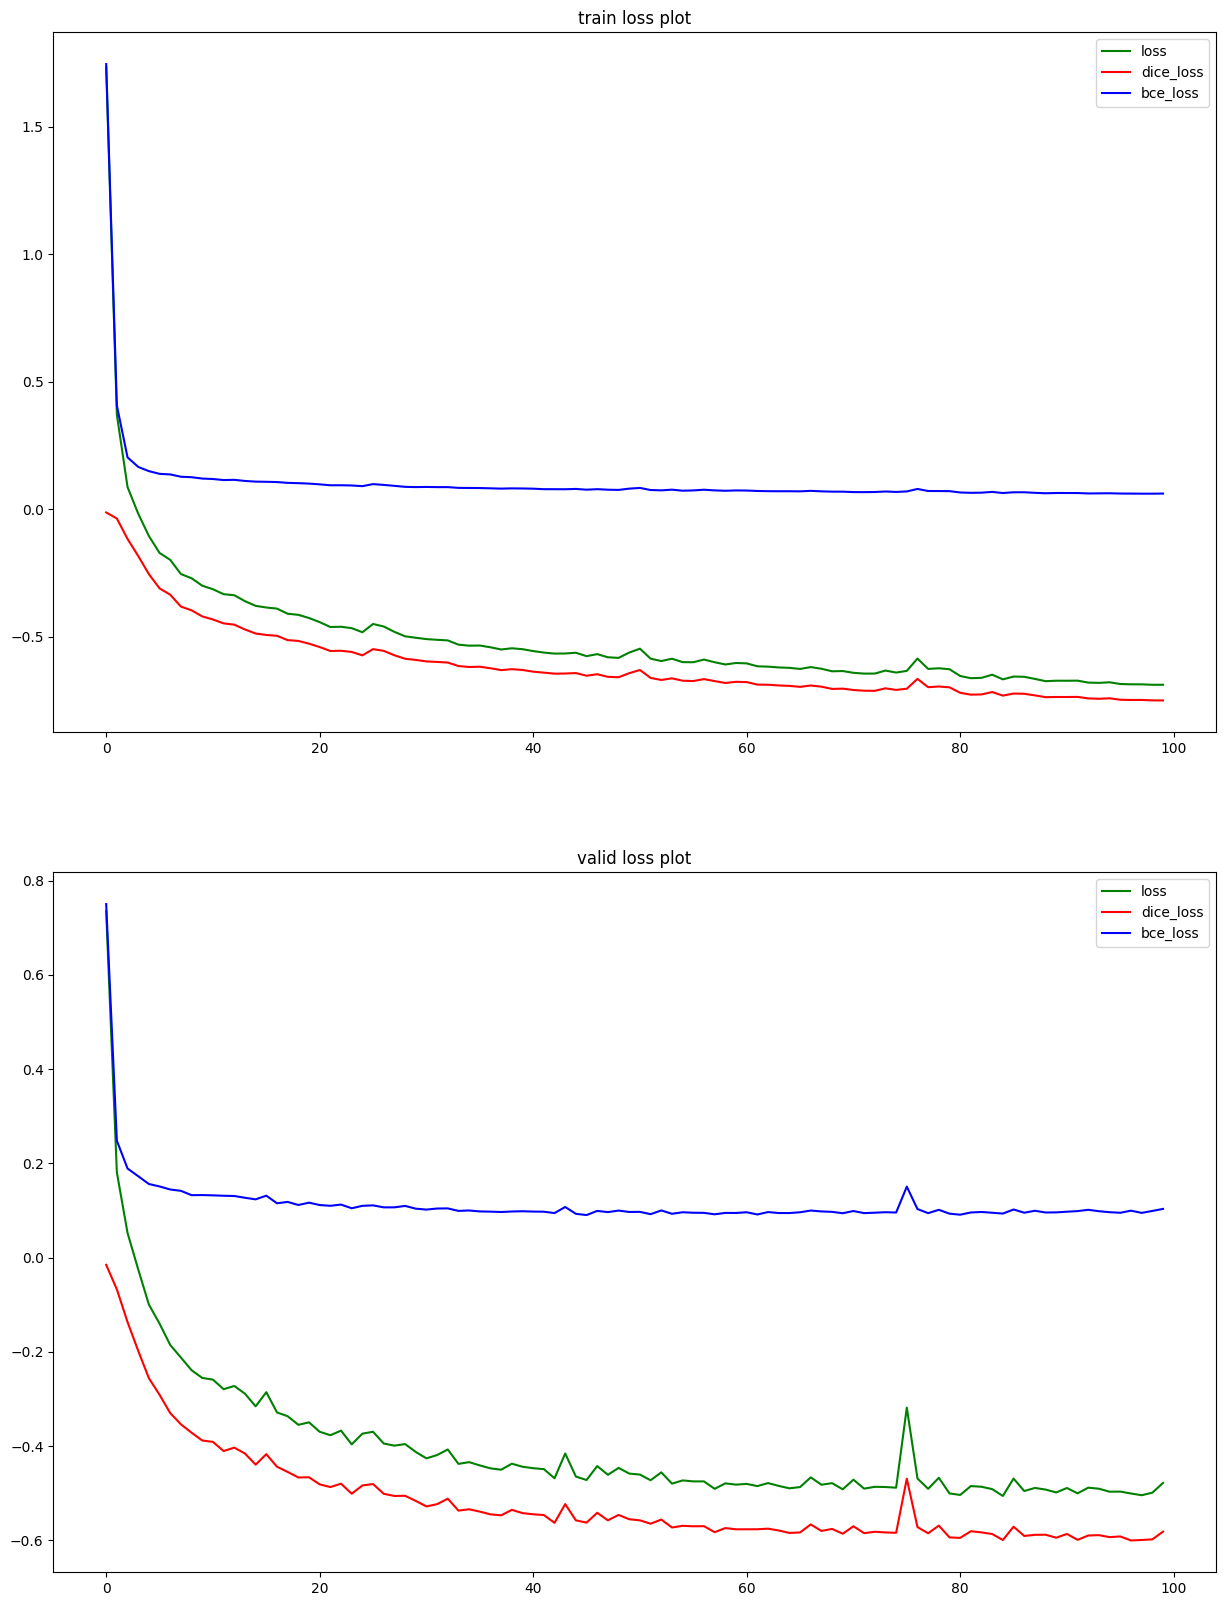

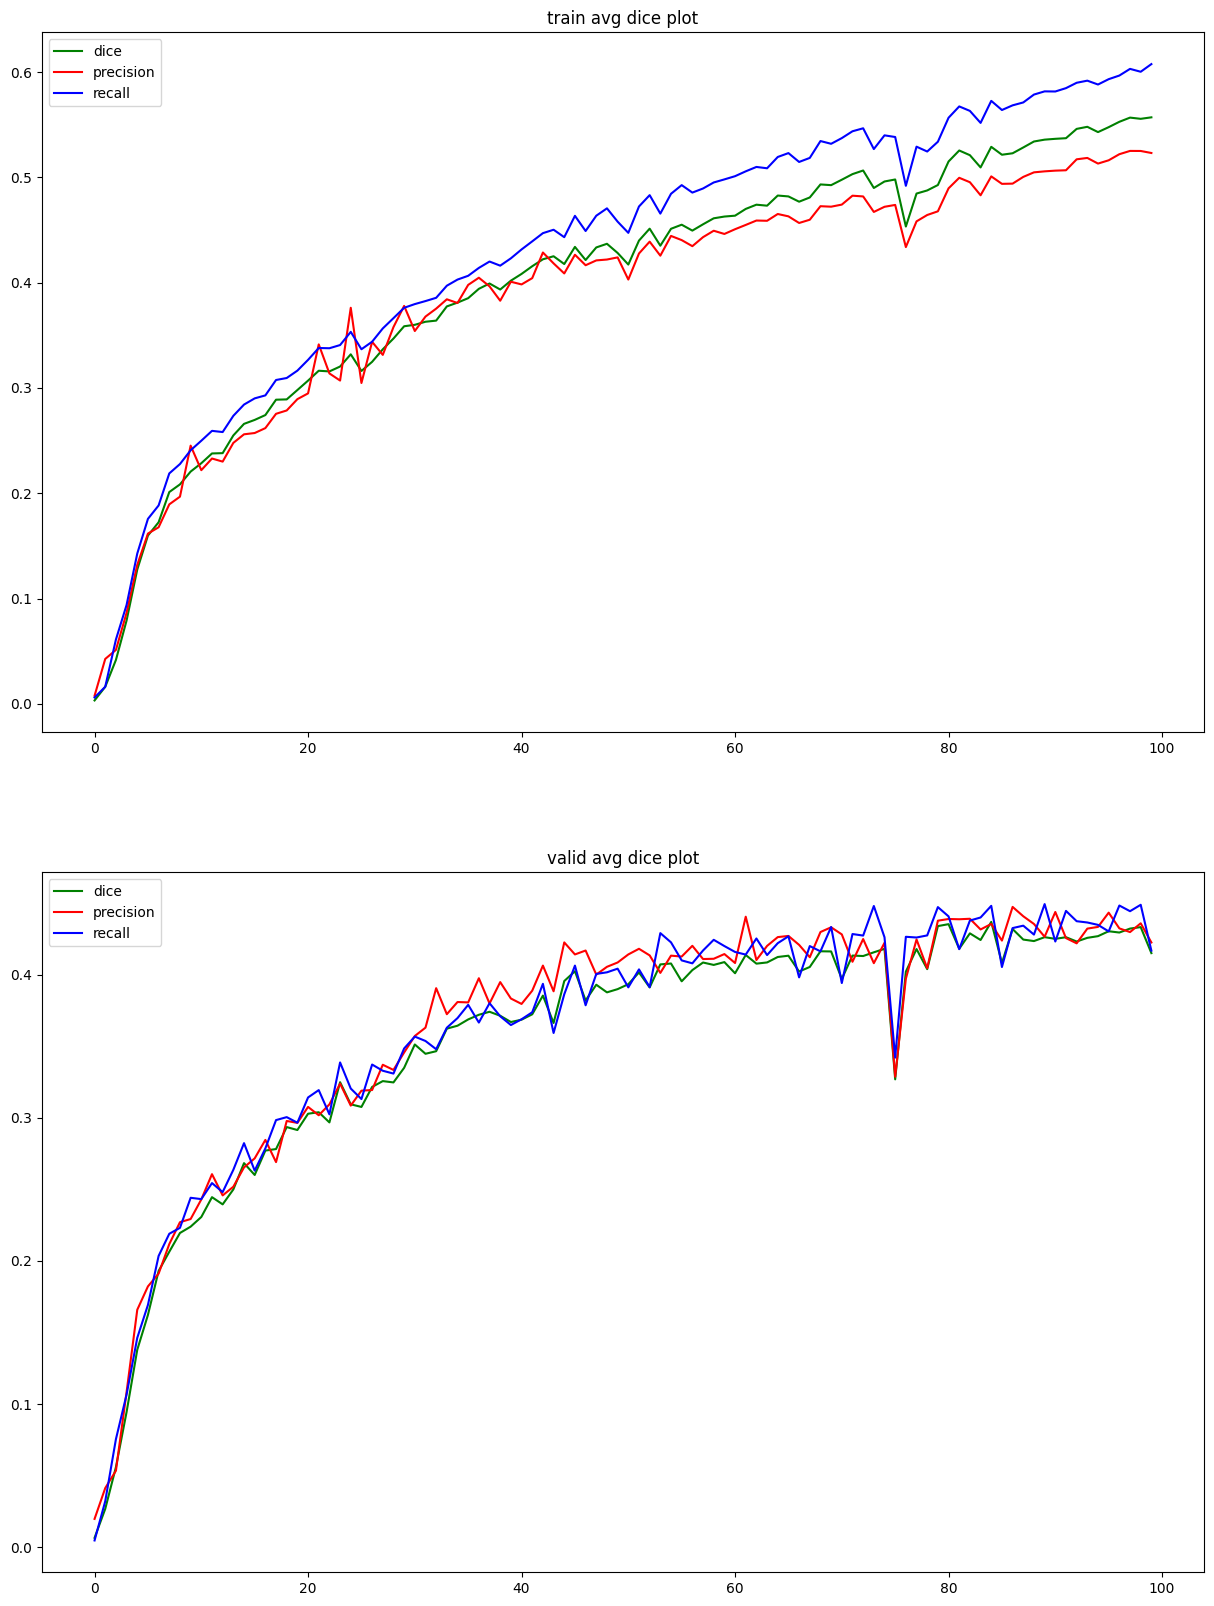

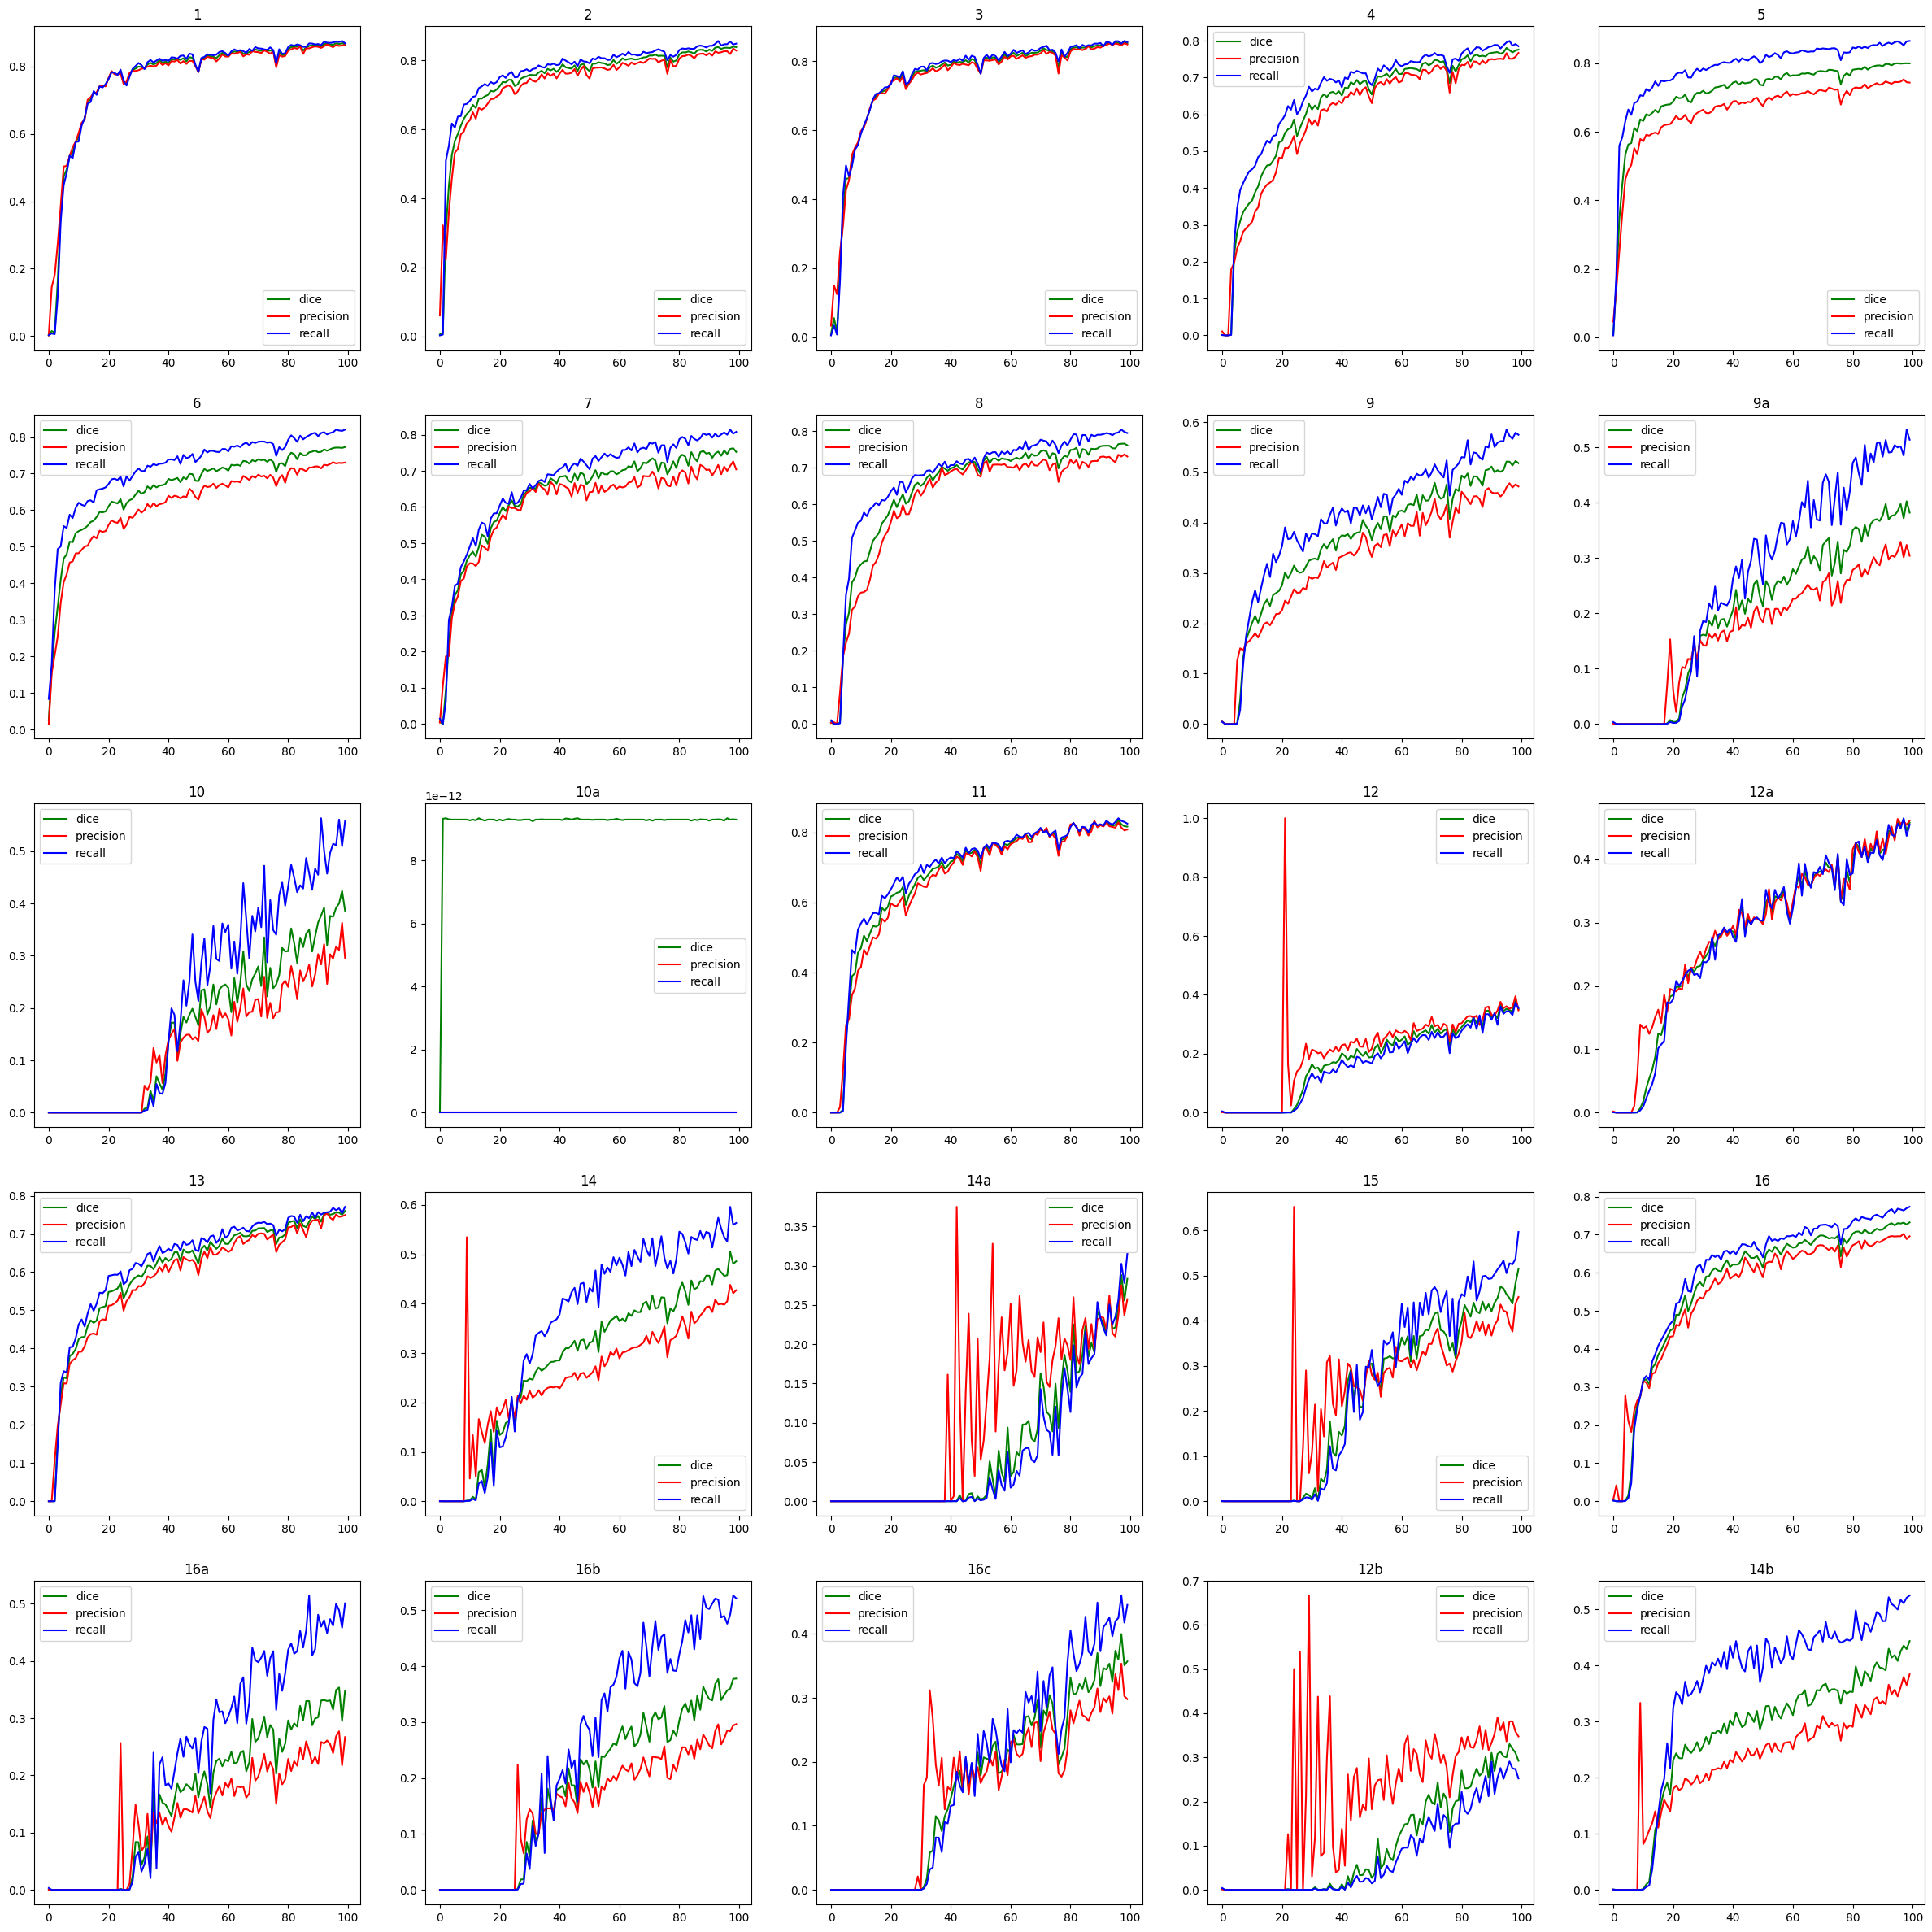

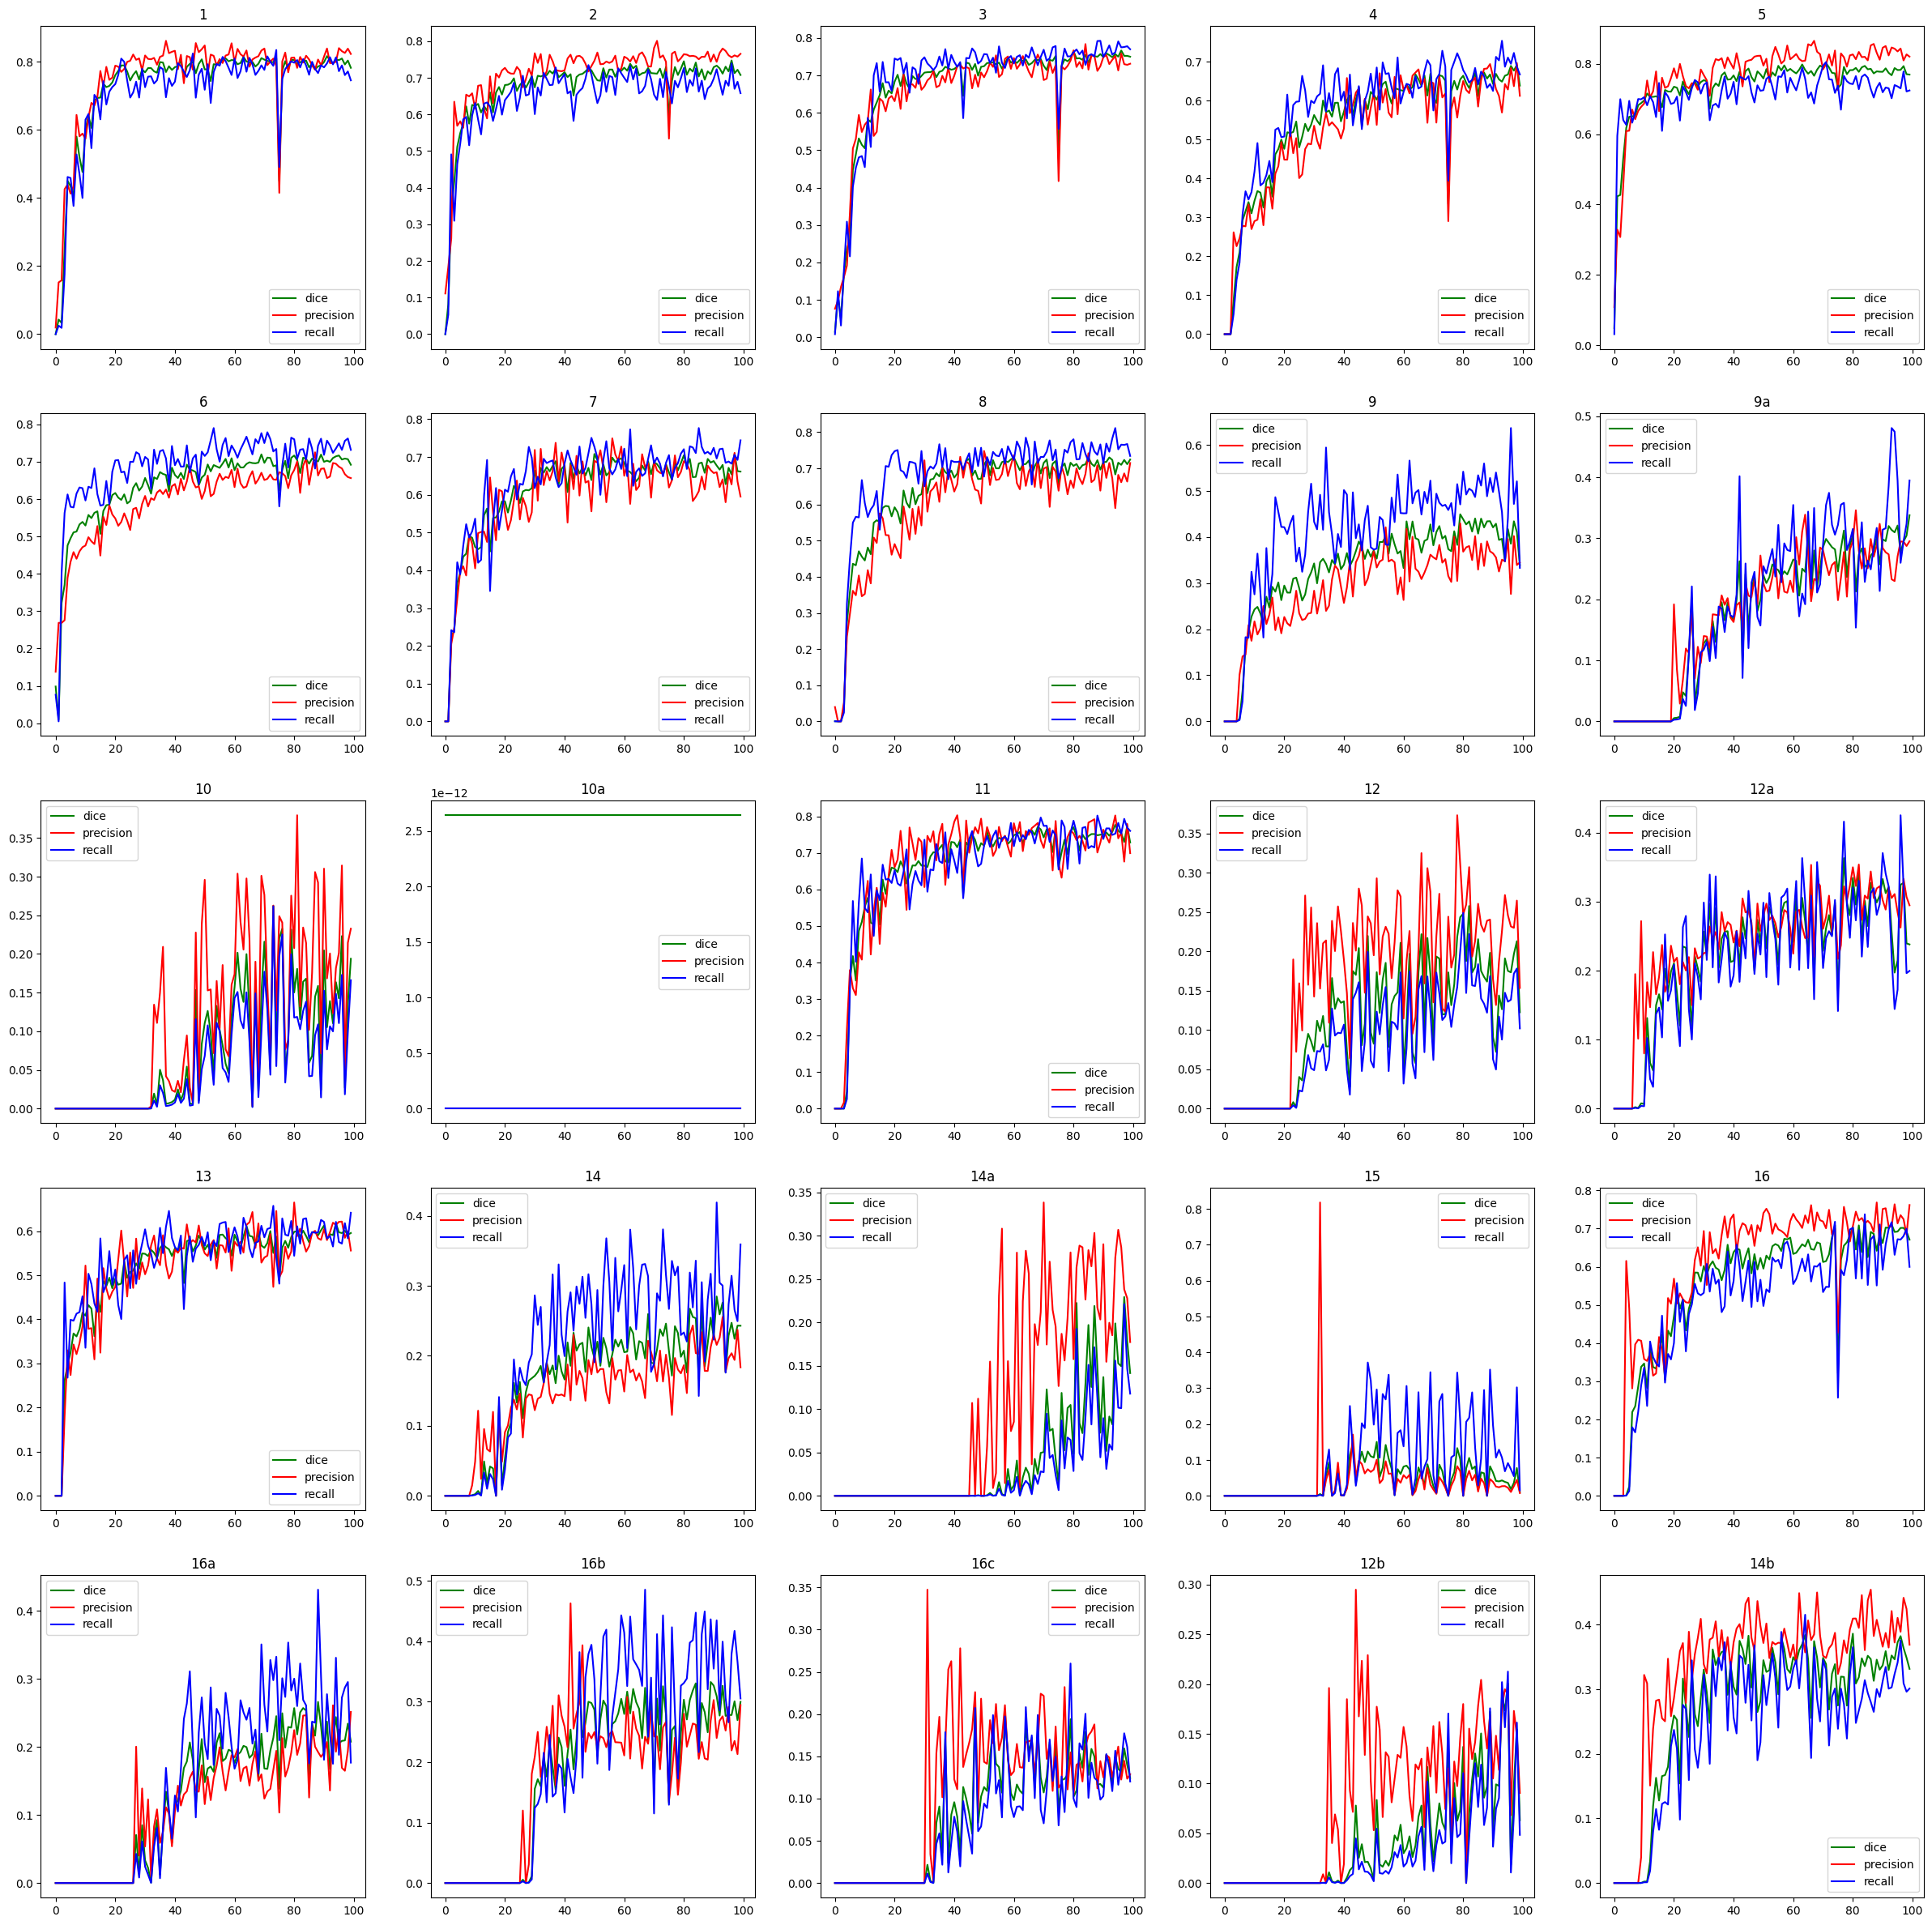

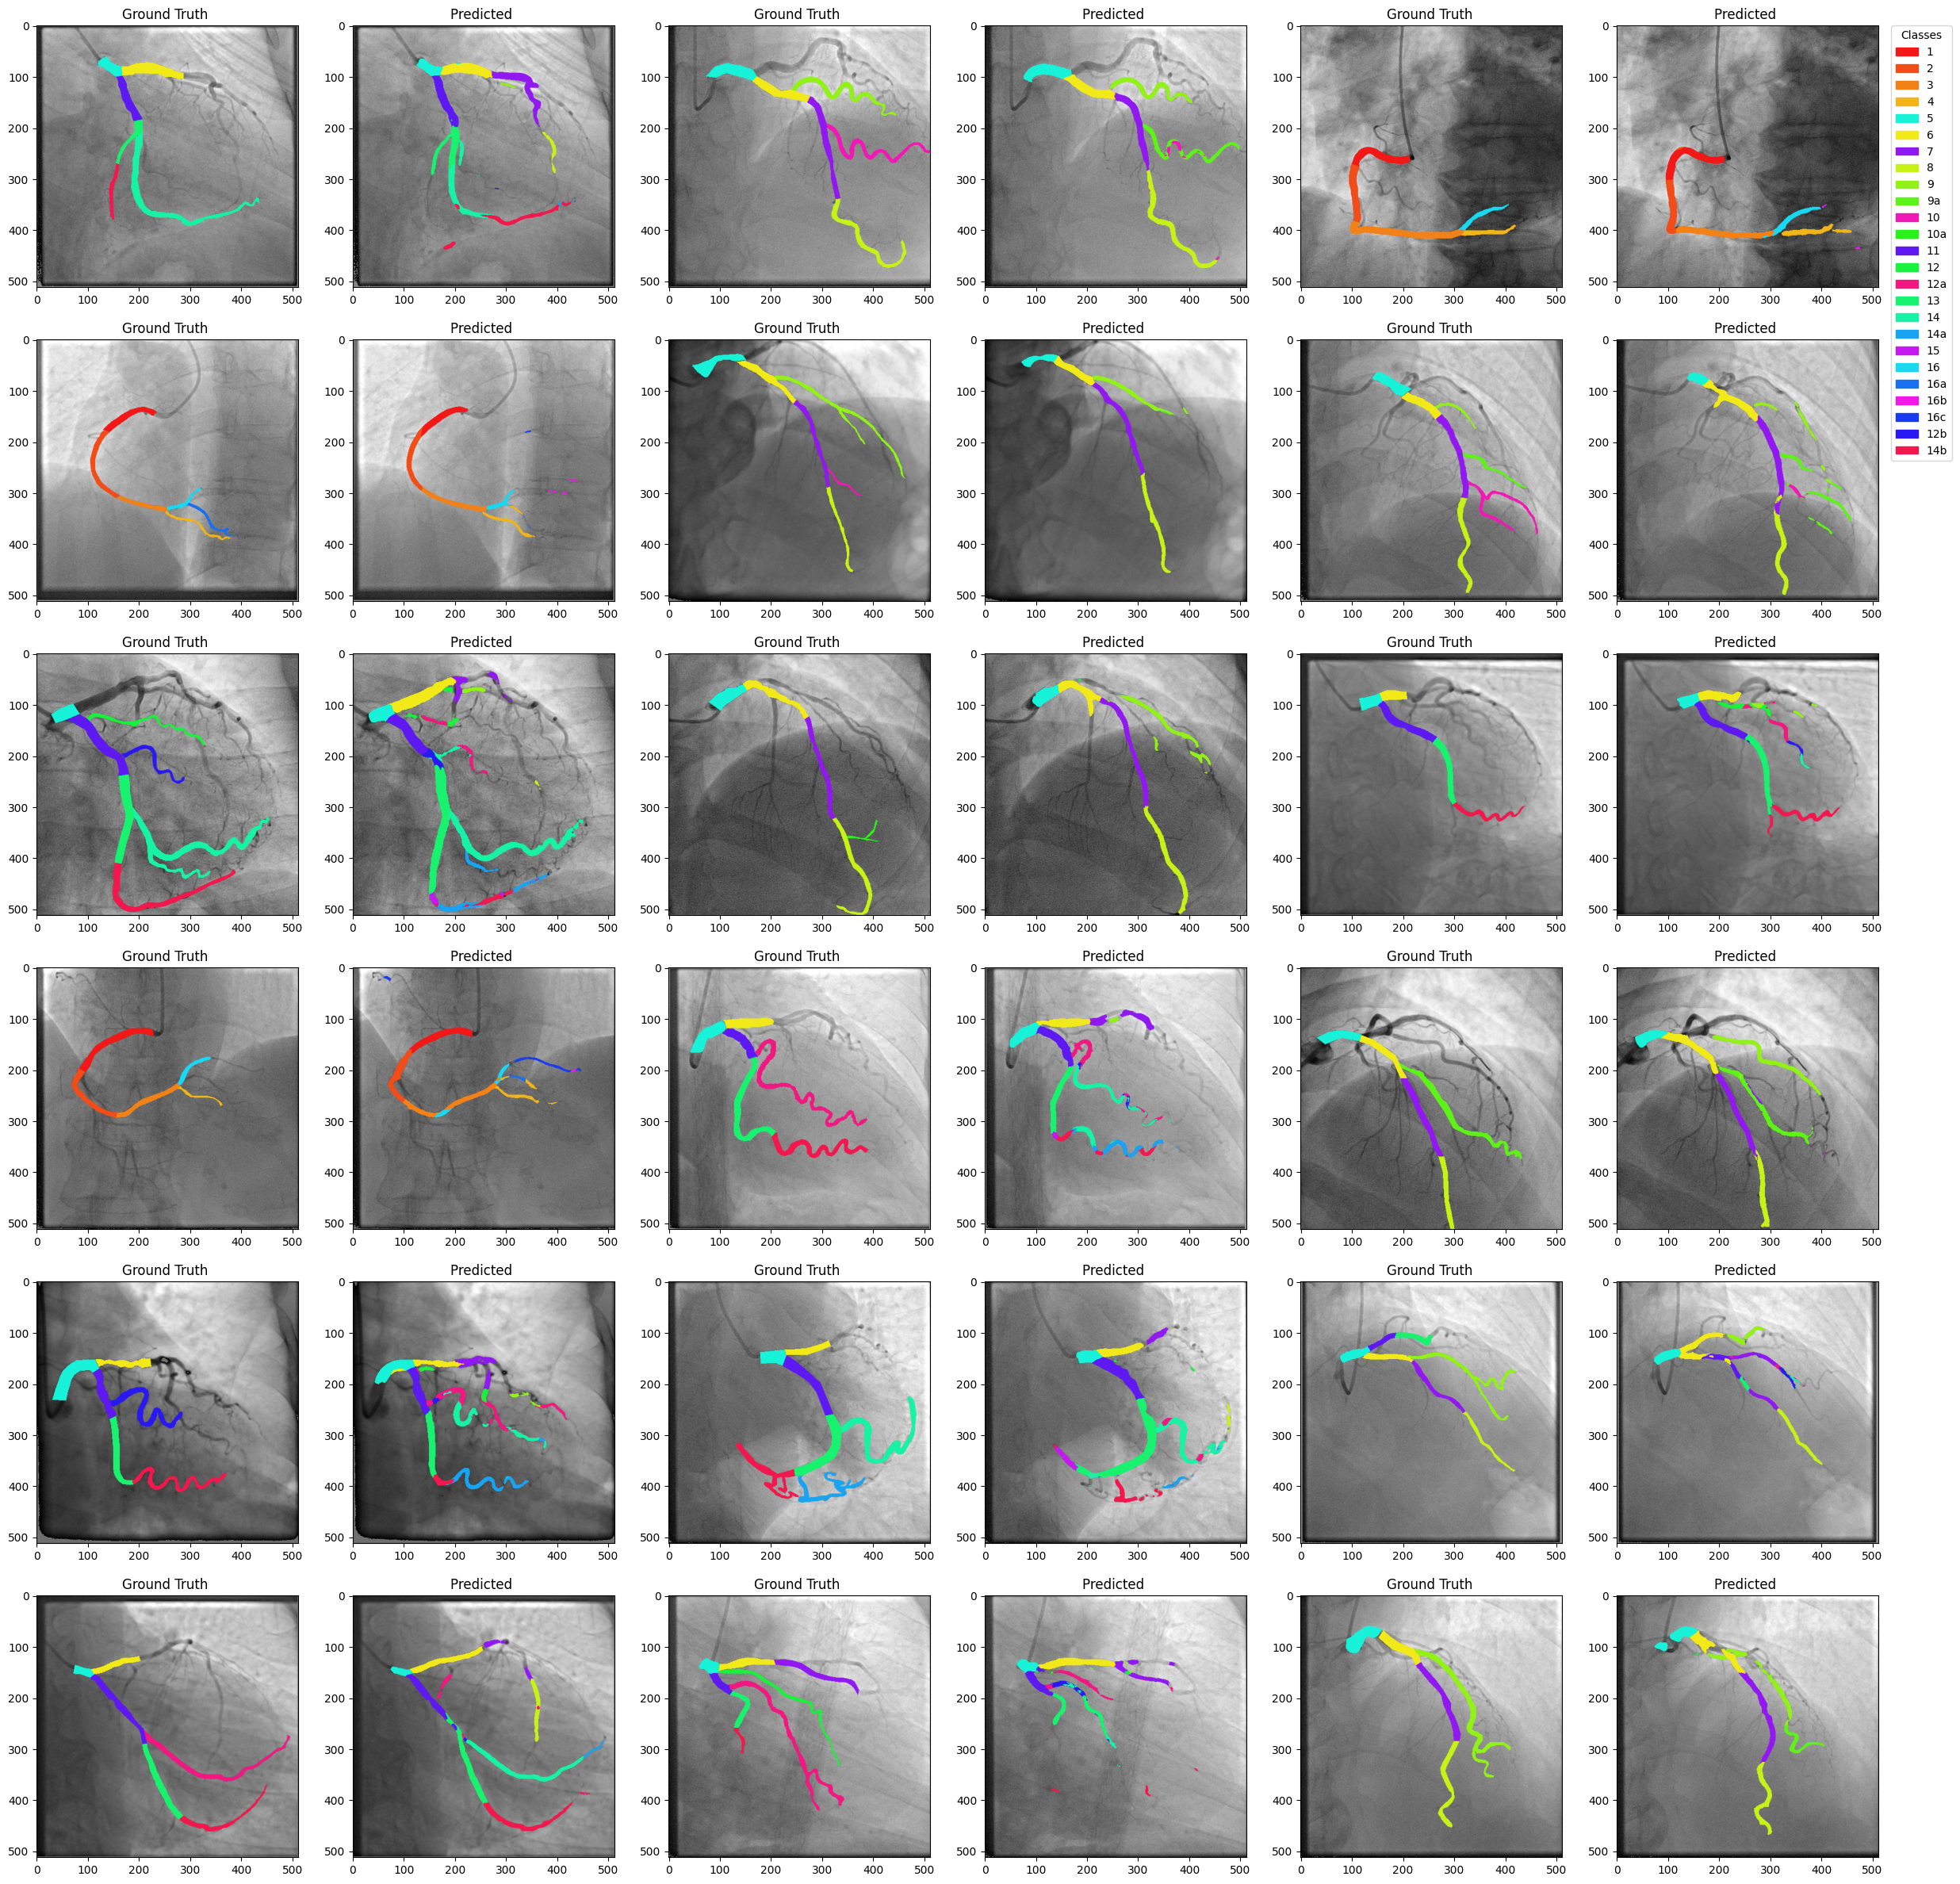

In [7]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)